In [1]:
from obspy.core import Stream, read
import numpy as np
from pytensor.compile.ops import as_op
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
import pymc as pm
import arviz as az

In [2]:
# What exactly are the colunns here? Amplitude of waves at a specific time?
# My equivalent = peak strain at a specific time

# Build the target function, misfit to this is what is being minimized
@as_op(itypes=[pt.dvector,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar], otypes=[pt.dvector])
def two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    y_out = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    y_out = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    y_out[i] = m2*x[i] + b2

    return y_out

# Build the target function, misfit to this is what is being minimized
def non_pytensor_two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    yout = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    yout = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    yout[i] = m2*x[i] + b2

    return yout

In [3]:
def get_xhigh(eq_id):
    
    if eq_id == '2023-04-13_M6':
        xhigh = 60
    elif eq_id == '2022-12-20_M6.4':
        if hypdist < 200:
            xhigh = 20
        else:
            xhigh = 40
    elif eq_id == '2022-11-22_M6.2': # Weird one that pauses for a while then grows again
        xhigh = 25
    elif eq_id == '2021-12-20_M6.2':
        if hypdist < 30: 
            xhigh = 20
        elif 30 < hypdist < 50:
            xhigh = 25
        elif 50 < hypdist < 100:
            xhigh = 30
        else:
            xhigh = 60
    elif eq_id == '2021-07-08_M6': # Lots of more gradual ones with pause again
        if hypdist < 300:
            xhigh = 25
        else:
            xhigh = 50
    elif eq_id == '2020-05-15_M6.5':
        xhigh = 30
    elif eq_id == '2020-03-31_M6.5':
        xhigh = 35
    elif eq_id == '2019-12-25_M6.3':
        xhigh = 35
    elif eq_id == '2019-12-23T20_M6':
        xhigh = 60
    elif eq_id == '2019-12-23T19_M6':
        xhigh = 60
    elif eq_id == '2019-08-29_M6.3': # All flatten fast
        xhigh = 60
    elif eq_id == '2019-07-06_M7.1': # Ridgecrest mainshock
        xhigh = 27
    elif eq_id == '2019-07-04_M6.4': # Ridgecrest foreshock
        if hypdist < 50:
            xhigh = 20
        else:
            xhigh = 27
    elif eq_id == '2019-07-04_M6.2':
        xhigh = 35
    # elif eq_id == '2018-10-22T06_M6.5': # No waveforms with high enough SNR
    #     xhigh = 
    elif eq_id == '2018-10-22_M6.8': # Has like 3 slopes? Letting it go long
        xhigh = 60
    elif eq_id == '2018-10-22T05_M6.5': # Somewhat of a pause but all similar? Going long
        xhigh = 60
    elif eq_id == '2018-08-22_M6.2':
        xhigh = 60
    elif eq_id == '2016-12-08_M6.6':
        xhigh = 60
    elif eq_id == '2014-08-24_M6.02':
        xhigh = 27
    elif eq_id == '2014-04-24_M6.5':
        xhigh = 50
    elif eq_id == '2014-03-10_M6.8':
        if hypdist < 110:
            xhigh = 25
        else:
            xhigh = 40
    elif eq_id == '2013-09-04_M6':
        xhigh = 25
    elif eq_id == '2013-09-03_M6.1':
        xhigh = 30
    elif eq_id == '2012-12-14_M6.3':
        xhigh = 25
    elif eq_id == '2012-11-08_M6.1':
        xhigh = 42
    elif eq_id == '2012-04-11_M6':
        xhigh = 30
    elif eq_id == '2011-09-09_M6.4':
        xhigh = 35
    elif eq_id == '2010-04-04_M7.2':
        xhigh = 35
    elif eq_id == '2010-01-10_M6.5':
        xhigh = 35
    elif eq_id == '2008-01-10_M6.3':
        xhigh = 24
    else:
        xhigh = 'no data'
    
    return xhigh

In [4]:
# Events

path_to_files = '/Users/sydneydybing/StrainProject/2024/'

earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)

In [5]:
# earthquakes

In [6]:
weird_events_only = False
if weird_events_only:
    earthquakes = earthquakes.iloc[[4,15]]

small_test = False
if small_test:
    earthquakes = earthquakes.iloc[[11,12,13]]
    
one_at_a_time = False
if one_at_a_time:
#     earthquakes = earthquakes[:1]
    earthquakes = earthquakes.iloc[[29]]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

# Stations

bsm_mda = pd.read_csv(path_to_files + 'bsm_metadata.csv')
NA_only = bsm_mda.loc[bsm_mda['LONG'] < -110]
stas = NA_only['BNUM'].values

eqs_test = earthquakes[4:5]
ots_test = origin_times[4:5]
mags_test = mags[4:5]
rows_for_extra_times = [8,9,14,16]

dist_array = np.load(path_to_files + 'NA_evt-sta_dist_array_less500km_withdata_withrmssnrs_3COMP.npy')

# Array order:

# 0. Earthquake identifier
# 1. Earthquake origin time
# 2. Earthquake latitude
# 3. Earthquake longitude
# 4. Earthquake magnitude
# 5. Station name
# 6. Station latitude
# 7. Station longitude
# 8. Hypocentral distance (km)
# 9. RMS strain SNR

In [7]:
events_list = []
mags_list = []
stas_list = []
hypdist_list = []
xhighs_list = []
m1s_list = []
m2s_list = []
xinters_list = []
sigmas_list = []
trans_time_list = []

counter = 0

for idx in range(len(dist_array)):
    
    eq_id = dist_array[idx,0]
    mag = dist_array[idx,4]
    sta = dist_array[idx,5]

    # print(eq_id, sta)

    # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)

    xlow = 10
    xhigh = get_xhigh(eq_id)
        
    try:

        hypdist = float(dist_array[idx,8])
        int_hypdist = int(hypdist)
        snr = float(dist_array[idx,9])
        int_snr = int(snr) # Breaks try condition if snr is nan
        
        # Read in data - peak strain data only has the ones with SNR > 2
        pst = read(path_to_files + 'strain_data/3comp_peak_post_p/' + str(eq_id) + '/' + str(sta) + '.mseed')
        counter += 1
        # print(counter)
        # pst.plot()
        # plt.plot(pst[0].times(), pst[0].data)
        # plt.semilogy()

        print('Processing ' + str(eq_id) + ', ' + str(sta))

    except:
        continue # skips to next station

    print('Processing ' + str(sta))
        
    times = pst[0].times()
    data = pst[0].data
    log10_data = np.log10(data)
    samp_rate = pst[0].stats.sampling_rate
    print(samp_rate)

    vec_start = int(xlow*samp_rate)
    vec_end = int(xhigh*samp_rate)
    
    ####### NEW THING TRYING
    norm_data = np.copy(data)
    norm_level = data[0]
#         print(norm_level)
    norm_data = norm_data - norm_level + 1*10**-9 # Subtract the starting value, add 10^-9 to set at 10^0 on nanostrain plot

    norm_log10data = np.log10(norm_data)
    yobserved = norm_log10data[vec_start:vec_end]
    
    ######

    # Split into x and y vectors
    xobserved = times[vec_start:vec_end]
    # yobserved = log10_data[vec_start:vec_end]
    x0 = xobserved[0]
    y0 = yobserved[0]

    # in order to pass the x variable into the target function it needs to be 
    # converted to a Theano "shared" variable
    pt_xobserved = pytensor.shared(xobserved)
    pt_x0 = pytensor.shared(x0)
    pt_y0 = pytensor.shared(y0)

    # MCMC run parameters, these are good numbers for a "production" run. If you are
    # fooling arund these can be lower to iterate faster
    Nburn = 5000 # burn in samples that get discarded
    Nmcmc = 15000 # bump to at least 5-10k
    Nchains = 4
    Ncores = 1

    # Bounds for the prior distributions
    m1_low = -1; m1_high = 5
    m2_low = -1; m2_high = 1
    xinter_low = 10 ; xinter_high = 25 # location of the line slope change

    # Define the Bayesian model
    with pm.Model()as model:

        # Use normal distributions as priors
        # m1 = pm.Normal('m1', mu = 0.5, sigma = 1)
        # m2 = pm.Normal('m2', mu = -0.1, sigma = 5)
        m1 = pm.Uniform('m1', lower = m1_low, upper = m1_high)
        m2 = pm.Uniform('m2', lower = m2_low, upper = m2_high)
        xinter = pm.Uniform('xinter', lower = xinter_low, upper = xinter_high)
        sigma = pm.HalfCauchy('sigma', beta = 10, initval = 1)

        # This is the model
        likelihood = pm.Normal('y', mu = two_straight_lines(pt_xobserved,m1,m2,xinter,pt_x0,pt_y0),
                                observed = yobserved, sigma = sigma)

        # NUTS sampler (default) is gradient based and won't work, use metropolis
        step = pm.Metropolis(scaling = 0.1)

        # This runs the mcmc sampler
        mcmc = pm.sample(Nmcmc, tune = Nburn, chains = Nchains, cores = Ncores, step = step)

    # Done, now is post-processing to get the data out of the sampler

    posterior = az.extract(mcmc)

    # Unwrap coeficients - WRITE LINES TO SAVE THE ARRAYS!!!
    m1_array = posterior.m1.values
    m1 = np.mean(m1_array)
    # print('m1 mean: ' + str(round(m1,2)))

    m2_array = posterior.m2.values
    m2 = np.mean(m2_array)
    # print('m2 mean: ' + str(round(m2,2)))

    xinter_array = posterior.xinter.values
    xinter = np.mean(xinter_array)
    # print('xinter Mean: ' + str(round(xinter,2)))

    sigma_array = posterior.sigma.values
    sigma = np.mean(sigma_array)

    # Lines!
    b1 = y0 - m1*x0
    b2 = m1*xinter + b1 - m2*xinter

    # Make plot to check stuff
    xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
    ypredicted = m1*xpredicted + b1
    i = np.where(xpredicted > xinter)[0]
    ypredicted[i] = m2*xpredicted[i] + b2

    # Get one-sigma region (need to obtain a ton of forward models and get stats)
    N = len(posterior.m1.values)

    yfit = np.zeros((len(xpredicted), N))
    for k in range(N):
        yfit[:,k] = non_pytensor_two_straight_lines(xpredicted,m1_array[k],m2_array[k],xinter_array[k],x0,y0)
    mu = yfit.mean(1)
    sig = yfit.std(1) * 1.95 #for 95% confidence
    mu_plus = mu + sig
    mu_minus = mu - sig

    # Least squares
    mls, bls = np.polyfit(xobserved, yobserved, 1)

    # Find the transition point in ypredicted
    diff = np.round(np.diff(ypredicted), decimals = 5)
    # print(diff)
    first_slope = diff[0]
    second_slope = diff[-1]
    trans_idx = np.where((diff != first_slope) & (diff != second_slope))[0][0] + 1

    # Get the transition point
    mcmc_trans_x = xpredicted[trans_idx] # Number
    mcmc_trans_y = ypredicted[trans_idx]

    # Append things
    events_list.append(eq_id)
    mags_list.append(mag)
    stas_list.append(sta)
    hypdist_list.append(int_hypdist)
    xhighs_list.append(xhigh)
    m1s_list.append(m1)
    m2s_list.append(m2)
    xinters_list.append(xinter)
    sigmas_list.append(sigma)
    trans_time_list.append(mcmc_trans_x)

    # Create folder for the event
    array_save_dir = path_to_files + '3comp_norm_mcmc_arrays/' + str(eq_id) + '/' + str(sta) + '/'
    if os.path.isdir(array_save_dir):
        pass
    else:
        os.makedirs(array_save_dir)

    np.save(array_save_dir + 'xobserved.npy', xobserved)
    np.save(array_save_dir + 'yobserved.npy', yobserved)
    np.save(array_save_dir + 'xpredicted.npy', xpredicted)
    np.save(array_save_dir + 'ypredicted.npy', ypredicted)
    np.save(array_save_dir + 'forward_mus.npy', mu)
    np.save(array_save_dir + 'foward_sigs.npy', sig)

    summary = az.summary(mcmc, fmt = 'wide')
    print(summary)
    summary.to_csv(array_save_dir + 'mcmc_summary.csv', index = False)

    # Folder for figures
    fig_save_dir = path_to_files + 'figures/3comp_norm_mcmc_plots/' + str(eq_id) + '/'
    if os.path.isdir(fig_save_dir):
        pass
    else:
        os.makedirs(fig_save_dir)

    az.plot_trace(mcmc)
    # plt.show()
    plt.savefig(fig_save_dir + sta + '_stats_plots.png', format = 'PNG')
    plt.close()

    # Plot all solutions
    fig = plt.figure(dpi = 100)
    ax = fig.add_subplot(111)
    ax.set_title(str(sta))

    ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)')
    ax.plot(xpredicted, ypredicted, color = 'red', label = 'Predicted (MCMC)')
    # ax.plot(xpredicted, mu, color = 'green', linestyle = '--', label = 'yfit')
    # ax.plot(xpredicted, xpredicted * mls + bls, color = 'orange', label = 'np.polyfit least squares')
    ax.scatter(xpredicted[trans_idx], ypredicted[trans_idx], marker = 'o', color = 'black', label = 'Transition at ' + str(round(xpredicted[trans_idx],2)) + ' sec')
    # ax.scatter(closest_trans_x, closest_trans_y, marker = 'o', color = 'green', label = 'Adjusted transition at ' + str(round(closest_trans_x,2)) + ' sec')
    # ax2 = ax.twinx()
    # ax2.plot(xobserved, pythags_arr, color = 'violet')
    # ax2.axhline(closest_trans_x, color = 'violet', linestyle = '--')
    ax.fill_between(xpredicted, mu_plus, mu_minus, color = 'gray', alpha = 0.2, label = '95% confidence') # 95% confidence interval
    ax.set_xlabel('Time (s) - p-wave at 10s')
    ax.set_ylabel('log10 of peak strain')
    # ax.set_xlim(10,13)
    ax.legend()

    # plt.show()

    plt.savefig(fig_save_dir + sta + '.png', format = 'PNG')
    plt.close()

Processing 2023-04-13_M6, B006
Processing B006
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 171 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.229  0.046   0.171    0.318      0.022    0.017       4.0   
m2       0.007  0.000   0.007    0.007      0.000    0.000       8.0   
xinter  11.838  0.374  11.232   12.386      0.185    0.141       4.0   
sigma    0.042  0.001   0.040    0.044      0.000    0.000      23.0   

        ess_tail  r_hat  
m1          11.0   4.06  
m2          52.0   1.47  
xinter      11.0   3.99  
sigma       93.0   1.11  
Processing 2023-04-13_M6, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 164 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.212  0.020   0.184    0.246      0.009    0.007       5.0   
m2       0.019  0.000   0.018    0.019      0.000    0.000      26.0   
xinter  12.735  0.280  12.273   13.197      0.127    0.096       5.0   
sigma    0.085  0.002   0.081    0.088      0.000    0.000    9757.0   

        ess_tail  r_hat  
m1          12.0   2.16  
m2          76.0   1.14  
xinter      13.0   2.13  
sigma    11322.0   1.00  
Processing 2023-04-13_M6, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 166 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.680  0.163   0.427    0.954      0.081    0.062       4.0   
m2       0.009  0.000   0.009    0.009      0.000    0.000       6.0   
xinter  11.372  0.374  10.899   12.058      0.182    0.139       4.0   
sigma    0.053  0.005   0.046    0.064      0.003    0.002       5.0   

        ess_tail  r_hat  
m1          11.0   3.46  
m2          21.0   1.66  
xinter      11.0   3.47  
sigma       11.0   2.47  
Processing 2023-04-13_M6, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 173 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.407  0.021   0.375    0.444      0.010    0.007       5.0   
m2       0.012  0.000   0.012    0.012      0.000    0.000      16.0   
xinter  11.760  0.092  11.609   11.918      0.043    0.032       5.0   
sigma    0.055  0.001   0.052    0.057      0.000    0.000    9692.0   

        ess_tail  r_hat  
m1          12.0   2.21  
m2          62.0   1.19  
xinter      11.0   2.19  
sigma    11555.0   1.00  
Processing 2022-12-20_M6.4, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 162 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.251  0.005   0.242    0.259      0.001    0.000      67.0   
m2       0.035  0.001   0.034    0.037      0.000    0.000      88.0   
xinter  14.229  0.098  14.051   14.425      0.013    0.009      57.0   
sigma    0.123  0.004   0.117    0.130      0.000    0.000   12246.0   

        ess_tail  r_hat  
m1         102.0   1.08  
m2         149.0   1.05  
xinter     121.0   1.07  
sigma    13170.0   1.00  
Processing 2022-12-20_M6.4, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 163 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.321  0.005   0.311    0.329      0.002    0.001      10.0   
m2       0.030  0.000   0.029    0.031      0.000    0.000     101.0   
xinter  13.488  0.068  13.389   13.636      0.024    0.017      10.0   
sigma    0.075  0.002   0.071    0.079      0.000    0.000   11597.0   

        ess_tail  r_hat  
m1          24.0   1.33  
m2         119.0   1.04  
xinter      18.0   1.33  
sigma    12628.0   1.00  
Processing 2022-12-20_M6.4, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 183 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.199  0.097   1.012    1.346      0.043    0.033       5.0   
m2       0.028  0.001   0.027    0.029      0.000    0.000      11.0   
xinter  11.409  0.132  11.219   11.659      0.057    0.043       5.0   
sigma    0.105  0.004   0.098    0.113      0.001    0.001      19.0   

        ess_tail  r_hat  
m1          25.0   2.16  
m2          69.0   1.27  
xinter      25.0   2.15  
sigma       46.0   1.13  
Processing 2022-12-20_M6.4, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 163 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.952  0.085   0.809    1.086      0.039    0.029       5.0   
m2       0.021  0.001   0.020    0.023      0.000    0.000       9.0   
xinter  11.696  0.171  11.454   12.005      0.078    0.059       5.0   
sigma    0.108  0.003   0.102    0.114      0.001    0.000      27.0   

        ess_tail  r_hat  
m1          12.0   2.35  
m2          44.0   1.39  
xinter      14.0   2.31  
sigma       68.0   1.09  
Processing 2022-12-20_M6.4, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 165 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.587  0.011   0.568    0.608      0.003    0.002      19.0   
m2       0.048  0.001   0.047    0.050      0.000    0.000     153.0   
xinter  12.636  0.056  12.537   12.744      0.012    0.009      22.0   
sigma    0.117  0.003   0.110    0.123      0.000    0.000   11543.0   

        ess_tail  r_hat  
m1          35.0   1.16  
m2         154.0   1.03  
xinter      31.0   1.14  
sigma    12978.0   1.00  
Processing 2022-12-20_M6.4, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 155 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.917  0.021   0.878    0.954      0.003    0.002      56.0   
m2       0.018  0.004   0.010    0.025      0.000    0.000     206.0   
xinter  11.947  0.055  11.848   12.054      0.008    0.005      54.0   
sigma    0.112  0.006   0.102    0.123      0.000    0.000   11905.0   

        ess_tail  r_hat  
m1         110.0   1.07  
m2         779.0   1.02  
xinter     112.0   1.08  
sigma    14656.0   1.00  
Processing 2022-12-20_M6.4, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 152 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.982  0.036   4.957    5.000      0.004    0.003      72.0   
m2       0.013  0.001   0.011    0.015      0.000    0.000     145.0   
xinter  10.798  0.008  10.788   10.806      0.001    0.001     114.0   
sigma    0.225  0.007   0.212    0.237      0.000    0.000    6122.0   

        ess_tail  r_hat  
m1         154.0   1.04  
m2         331.0   1.02  
xinter     195.0   1.03  
sigma     5500.0   1.00  
Processing 2022-12-20_M6.4, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 1432 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.785  0.378   2.210    3.446      0.149    0.111       7.0   
m2       0.149  0.004   0.142    0.156      0.001    0.001      20.0   
xinter  10.521  0.077  10.398   10.655      0.031    0.023       7.0   
sigma    0.120  0.006   0.108    0.131      0.000    0.000   11771.0   

        ess_tail  r_hat  
m1          42.0   1.58  
m2         289.0   1.14  
xinter      41.0   1.59  
sigma    14249.0   1.00  
Processing 2022-12-20_M6.4, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 4452 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.957  0.038   4.887    5.000      0.003    0.002      92.0   
m2       0.126  0.004   0.118    0.133      0.000    0.000     394.0   
xinter  10.467  0.006  10.457   10.478      0.000    0.000     219.0   
sigma    0.152  0.008   0.138    0.167      0.000    0.000   10050.0   

        ess_tail  r_hat  
m1          89.0   1.04  
m2         917.0   1.02  
xinter     502.0   1.02  
sigma    12785.0   1.00  
Processing 2022-11-22_M6.2, B081
Processing B081
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 3569 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.123  0.840   2.244    4.995      0.338    0.252       7.0   
m2       0.059  0.001   0.057    0.061      0.000    0.000     118.0   
xinter  10.170  0.059  10.127   10.303      0.024    0.018       8.0   
sigma    0.091  0.004   0.084    0.099      0.001    0.001      38.0   

        ess_tail  r_hat  
m1          11.0   1.52  
m2         455.0   1.05  
xinter      11.0   1.51  
sigma       49.0   1.06  
Processing 2022-11-22_M6.2, B086
Processing B086
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 2837 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.262  0.006   0.252    0.273      0.001    0.000      71.0   
m2       0.053  0.002   0.049    0.057      0.000    0.000     163.0   
xinter  13.834  0.138  13.563   14.083      0.017    0.012      65.0   
sigma    0.090  0.004   0.083    0.097      0.000    0.000   13288.0   

        ess_tail  r_hat  
m1         187.0   1.05  
m2         470.0   1.02  
xinter     207.0   1.06  
sigma    14763.0   1.00  
Processing 2022-11-22_M6.2, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 8544 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.395  0.010   0.374    0.413      0.001    0.001      57.0   
m2       0.044  0.003   0.039    0.049      0.000    0.000     382.0   
xinter  13.404  0.122  13.185   13.651      0.015    0.011      66.0   
sigma    0.131  0.005   0.121    0.141      0.000    0.000   12161.0   

        ess_tail  r_hat  
m1         125.0   1.08  
m2         713.0   1.01  
xinter     178.0   1.06  
sigma    14478.0   1.00  
Processing 2022-11-22_M6.2, B093
Processing B093
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 4596 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.103  0.001   0.101    0.105      0.000    0.000     123.0   
m2       0.007  0.008  -0.008    0.022      0.000    0.000     345.0   
xinter  20.553  0.291  20.014   21.105      0.021    0.015     199.0   
sigma    0.080  0.003   0.074    0.086      0.000    0.000   13998.0   

        ess_tail  r_hat  
m1         241.0   1.04  
m2        1105.0   1.01  
xinter     609.0   1.03  
sigma    14859.0   1.00  
Processing 2022-11-22_M6.2, B946
Processing B946
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 4205 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.214  0.004   0.205    0.221      0.001    0.000      41.0   
m2       0.069  0.003   0.064    0.074      0.000    0.000     123.0   
xinter  14.998  0.219  14.626   15.461      0.036    0.026      43.0   
sigma    0.091  0.004   0.084    0.098      0.000    0.000   12679.0   

        ess_tail  r_hat  
m1          67.0   1.09  
m2         296.0   1.04  
xinter      67.0   1.09  
sigma    14754.0   1.00  
Processing 2021-12-20_M6.2, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 3907 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.090  0.001   0.089    0.091      0.000    0.000      47.0   
m2       0.006  0.000   0.005    0.007      0.000    0.000      26.0   
xinter  23.958  0.169  23.647   24.286      0.031    0.022      30.0   
sigma    0.115  0.003   0.110    0.120      0.000    0.000   10968.0   

        ess_tail  r_hat  
m1          46.0   1.06  
m2          63.0   1.12  
xinter      60.0   1.10  
sigma    11648.0   1.00  
Processing 2021-12-20_M6.2, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 3544 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.137  0.001   0.134    0.138       0.00    0.000      22.0   
m2       0.013  0.000   0.012    0.013       0.00    0.000      80.0   
xinter  22.399  0.141  22.188   22.638       0.03    0.021      26.0   
sigma    0.124  0.003   0.119    0.129       0.00    0.000    6386.0   

        ess_tail  r_hat  
m1          25.0   1.14  
m2         148.0   1.03  
xinter      30.0   1.11  
sigma     5976.0   1.00  
Processing 2021-12-20_M6.2, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 177 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.119  0.001   0.118    0.121      0.000    0.000      32.0   
m2       0.006  0.000   0.005    0.007      0.000    0.000      70.0   
xinter  23.281  0.104  23.100   23.486      0.013    0.009      71.0   
sigma    0.112  0.003   0.107    0.117      0.000    0.000   10874.0   

        ess_tail  r_hat  
m1         151.0   1.10  
m2          84.0   1.07  
xinter     229.0   1.06  
sigma    11257.0   1.00  
Processing 2021-12-20_M6.2, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.834  0.220   0.513    1.244      0.107    0.082       5.0   
m2       0.029  0.000   0.028    0.030      0.000    0.000       6.0   
xinter  11.558  0.413  10.874   12.227      0.198    0.151       5.0   
sigma    0.111  0.005   0.103    0.121      0.002    0.001       7.0   

        ess_tail  r_hat  
m1          11.0   2.76  
m2          16.0   1.78  
xinter      11.0   2.75  
sigma       14.0   1.58  
Processing 2021-12-20_M6.2, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 144 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.583  0.107   0.426    0.752      0.049    0.037       5.0   
m2       0.024  0.001   0.023    0.025      0.000    0.000       7.0   
xinter  12.340  0.454  11.694   13.159      0.213    0.162       5.0   
sigma    0.168  0.004   0.161    0.175      0.000    0.000    8524.0   

        ess_tail  r_hat  
m1          11.0   2.37  
m2          34.0   1.57  
xinter      11.0   2.37  
sigma     9320.0   1.01  
Processing 2021-12-20_M6.2, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 129 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.302  0.862   2.643    5.000      0.389    0.298       6.0   
m2       0.009  0.001   0.007    0.011      0.000    0.000       8.0   
xinter  10.996  0.268  10.798   11.549      0.114    0.086       6.0   
sigma    0.290  0.025   0.258    0.343      0.011    0.008       6.0   

        ess_tail  r_hat  
m1          23.0   1.82  
m2          37.0   1.45  
xinter      23.0   1.87  
sigma       24.0   1.64  
Processing 2021-12-20_M6.2, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 161 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.771  0.011   0.751    0.791      0.001    0.001      54.0   
m2       0.000  0.002  -0.003    0.003      0.000    0.000     245.0   
xinter  11.574  0.024  11.528   11.620      0.003    0.002      50.0   
sigma    0.054  0.003   0.049    0.059      0.000    0.000   12210.0   

        ess_tail  r_hat  
m1         142.0   1.06  
m2         419.0   1.02  
xinter      85.0   1.05  
sigma    15469.0   1.00  
Processing 2021-12-20_M6.2, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 149 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.498  0.030   0.445    0.542      0.013    0.010       5.0   
m2       0.013  0.000   0.013    0.013      0.000    0.000      25.0   
xinter  11.547  0.097  11.402   11.726      0.044    0.033       5.0   
sigma    0.079  0.002   0.075    0.082      0.000    0.000   10113.0   

        ess_tail  r_hat  
m1          21.0   2.09  
m2          56.0   1.15  
xinter      16.0   2.06  
sigma    10434.0   1.01  
Processing 2021-12-20_M6.2, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 456 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.084  0.025   0.075    0.136      0.008    0.006      10.0   
m2       0.003  0.003   0.001    0.011      0.001    0.001      30.0   
xinter  23.801  2.992  16.037   25.000      1.024    0.761      14.0   
sigma    0.086  0.028   0.070    0.159      0.010    0.007      15.0   

        ess_tail  r_hat  
m1          24.0   1.29  
m2          25.0   1.29  
xinter      25.0   1.21  
sigma       25.0   1.18  
Processing 2021-12-20_M6.2, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.059  0.001   0.058    0.060      0.000    0.000       9.0   
m2       0.001  0.000   0.001    0.001      0.000    0.000      23.0   
xinter  24.936  0.294  24.930   25.000      0.053    0.038      36.0   
sigma    0.037  0.003   0.034    0.039      0.001    0.000      76.0   

        ess_tail  r_hat  
m1          24.0   1.35  
m2          27.0   1.14  
xinter      25.0   1.08  
sigma       24.0   1.03  
Processing 2021-12-20_M6.2, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 463 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.624  0.647   3.168    5.000      0.252    0.191       7.0   
m2       0.011  0.001   0.010    0.013      0.000    0.000      15.0   
xinter  10.791  0.153  10.703   11.133      0.057    0.042       7.0   
sigma    0.240  0.020   0.218    0.284      0.007    0.005       9.0   

        ess_tail  r_hat  
m1          22.0   1.60  
m2         158.0   1.18  
xinter      22.0   1.51  
sigma       22.0   1.35  
Processing 2021-12-20_M6.2, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 113 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.731  0.112   2.490    2.928      0.042    0.031       7.0   
m2       0.040  0.001   0.037    0.042      0.000    0.000      25.0   
xinter  10.747  0.034  10.688   10.819      0.013    0.009       7.0   
sigma    0.081  0.004   0.075    0.088      0.000    0.000     169.0   

        ess_tail  r_hat  
m1          22.0   1.60  
m2         162.0   1.12  
xinter      20.0   1.62  
sigma      283.0   1.02  
Processing 2021-12-20_M6.2, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.114  0.339   2.381    3.608      0.132    0.097       8.0   
m2       0.089  0.001   0.086    0.091      0.000    0.000      42.0   
xinter  10.517  0.068  10.432   10.670      0.026    0.019       7.0   
sigma    0.138  0.005   0.128    0.147      0.000    0.000     342.0   

        ess_tail  r_hat  
m1          23.0   1.49  
m2         281.0   1.08  
xinter      24.0   1.50  
sigma     2103.0   1.01  
Processing 2021-07-08_M6, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.105  0.010   0.098    0.127      0.003    0.003      11.0   
m2       0.015  0.005   0.011    0.025      0.001    0.001      20.0   
xinter  23.881  2.161  19.224   25.000      0.727    0.535      13.0   
sigma    0.142  0.012   0.130    0.168      0.004    0.003      16.0   

        ess_tail  r_hat  
m1          46.0   1.28  
m2          32.0   1.14  
xinter      42.0   1.23  
sigma       46.0   1.17  
Processing 2021-07-08_M6, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.417  0.018   0.397    0.444      0.008    0.006       6.0   
m2       0.007  0.001   0.006    0.008      0.000    0.000       9.0   
xinter  14.590  0.204  14.208   14.820      0.090    0.068       6.0   
sigma    0.085  0.003   0.079    0.090      0.001    0.001      16.0   

        ess_tail  r_hat  
m1          11.0   1.87  
m2          15.0   1.40  
xinter      11.0   1.88  
sigma       13.0   1.16  
Processing 2021-07-08_M6, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.285  0.004   0.278    0.291      0.000    0.000      54.0   
m2       0.027  0.003   0.021    0.033      0.000    0.000     207.0   
xinter  15.478  0.109  15.262   15.675      0.012    0.009      79.0   
sigma    0.102  0.004   0.094    0.109      0.000    0.000   12113.0   

        ess_tail  r_hat  
m1         153.0   1.07  
m2         558.0   1.02  
xinter     122.0   1.04  
sigma    13793.0   1.00  
Processing 2021-07-08_M6, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.158  0.001   0.155    0.160      0.000    0.000     139.0   
m2       0.064  0.002   0.060    0.069      0.000    0.000     251.0   
xinter  17.450  0.147  17.162   17.721      0.011    0.008     191.0   
sigma    0.062  0.003   0.057    0.067      0.000    0.000   13247.0   

        ess_tail  r_hat  
m1         249.0   1.01  
m2         514.0   1.02  
xinter     417.0   1.02  
sigma    15040.0   1.00  
Processing 2021-07-08_M6, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.213  0.003   0.207    0.220      0.000    0.000     137.0   
m2       0.078  0.002   0.074    0.081      0.000    0.000     269.0   
xinter  14.558  0.157  14.287   14.862      0.013    0.009     149.0   
sigma    0.081  0.003   0.075    0.087      0.000    0.000   13834.0   

        ess_tail  r_hat  
m1         229.0   1.01  
m2         605.0   1.01  
xinter     458.0   1.02  
sigma    14639.0   1.00  
Processing 2021-07-08_M6, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.149  0.002   0.146    0.151      0.000    0.000     181.0   
m2       0.078  0.007   0.065    0.090      0.000    0.000    1275.0   
xinter  19.681  0.286  19.144   20.216      0.009    0.006     995.0   
sigma    0.127  0.005   0.117    0.137      0.000    0.000   11960.0   

        ess_tail  r_hat  
m1         381.0   1.04  
m2        2011.0   1.01  
xinter    2323.0   1.01  
sigma    14864.0   1.00  
Processing 2021-07-08_M6, B073
Processing B073
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.161  0.004   0.158    0.169      0.001    0.001       9.0   
m2       0.003  0.001   0.001    0.005      0.000    0.000      11.0   
xinter  21.925  0.367  21.138   22.304      0.130    0.096       9.0   
sigma    0.095  0.003   0.090    0.100      0.000    0.000      76.0   

        ess_tail  r_hat  
m1          30.0   1.39  
m2          38.0   1.26  
xinter      29.0   1.37  
sigma      187.0   1.03  
Processing 2021-07-08_M6, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.188  0.003   0.183    0.195      0.001    0.001       7.0   
m2       0.012  0.000   0.011    0.013      0.000    0.000      20.0   
xinter  16.928  0.149  16.666   17.237      0.057    0.042       7.0   
sigma    0.073  0.002   0.070    0.077      0.000    0.000    7099.0   

        ess_tail  r_hat  
m1          13.0   1.58  
m2          30.0   1.17  
xinter      13.0   1.62  
sigma    10825.0   1.00  
Processing 2021-07-08_M6, B901
Processing B901
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.146  0.001   0.145    0.147      0.000    0.000       7.0   
m2       0.003  0.000   0.003    0.004      0.000    0.000      28.0   
xinter  22.684  0.060  22.592   22.792      0.017    0.012      11.0   
sigma    0.051  0.001   0.048    0.053      0.000    0.000    4061.0   

        ess_tail  r_hat  
m1          29.0   1.51  
m2         102.0   1.10  
xinter      51.0   1.26  
sigma     2702.0   1.00  
Processing 2021-07-08_M6, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.097  0.001   0.096    0.098      0.000    0.000      18.0   
m2       0.005  0.001   0.004    0.007      0.000    0.000      24.0   
xinter  24.969  0.030  24.911   25.000      0.002    0.002     163.0   
sigma    0.122  0.003   0.116    0.127      0.000    0.000   11748.0   

        ess_tail  r_hat  
m1          91.0   1.17  
m2         207.0   1.13  
xinter     396.0   1.03  
sigma    12117.0   1.00  
Processing 2021-07-08_M6, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.110  0.027   0.099    0.135      0.010    0.007       7.0   
m2       0.011  0.003   0.009    0.016      0.001    0.001      10.0   
xinter  21.339  1.922  17.903   22.586      0.802    0.612       8.0   
sigma    0.100  0.012   0.090    0.115      0.004    0.003      10.0   

        ess_tail  r_hat  
m1          11.0   1.57  
m2          12.0   1.38  
xinter      11.0   1.43  
sigma       11.0   1.28  
Processing 2020-05-15_M6.5, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.157  0.001   0.155    0.159      0.000    0.000     137.0   
m2       0.001  0.003  -0.004    0.007      0.000    0.000     435.0   
xinter  20.618  0.139  20.356   20.878      0.009    0.006     231.0   
sigma    0.110  0.004   0.103    0.117      0.000    0.000   13401.0   

        ess_tail  r_hat  
m1         140.0   1.03  
m2         777.0   1.01  
xinter     620.0   1.01  
sigma    14749.0   1.00  
Processing 2020-05-15_M6.5, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1      -0.011  0.169  -0.322    0.117      0.040    0.029       7.0   
m2       0.095  0.034   0.031    0.118      0.017    0.013       7.0   
xinter  14.454  5.942  10.178   24.998      2.952    2.268       7.0   
sigma    0.155  0.010   0.134    0.170      0.004    0.003       7.0   

        ess_tail  r_hat  
m1          33.0   1.57  
m2          36.0   1.54  
xinter      46.0   1.57  
sigma       27.0   1.52  
Processing 2020-05-15_M6.5, B921
Processing B921
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.018  0.209  -0.468    0.122      0.057    0.041       9.0   
m2       0.049  0.044   0.004    0.113      0.019    0.015       8.0   
xinter  19.483  6.330  10.019   24.520      2.817    2.123       8.0   
sigma    0.196  0.019   0.172    0.230      0.008    0.006       8.0   

        ess_tail  r_hat  
m1          96.0   1.41  
m2          66.0   1.46  
xinter     110.0   1.45  
sigma       51.0   1.43  
Processing 2020-03-31_M6.5, B944
Processing B944
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.118  0.001   0.117    0.120      0.000    0.000     105.0   
m2       0.039  0.002   0.036    0.042      0.000    0.000     469.0   
xinter  23.176  0.159  22.875   23.472      0.009    0.006     328.0   
sigma    0.095  0.003   0.090    0.101      0.000    0.000   12567.0   

        ess_tail  r_hat  
m1         167.0   1.03  
m2         711.0   1.01  
xinter    1030.0   1.01  
sigma    13877.0   1.00  
Processing 2019-12-25_M6.3, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.182  0.002   0.178    0.187      0.000    0.000      73.0   
m2       0.023  0.001   0.022    0.025      0.000    0.000     179.0   
xinter  15.232  0.088  15.064   15.397      0.008    0.006     116.0   
sigma    0.088  0.003   0.083    0.093      0.000    0.000   11757.0   

        ess_tail  r_hat  
m1          65.0   1.07  
m2         198.0   1.02  
xinter     284.0   1.04  
sigma    13232.0   1.00  
Processing 2019-12-25_M6.3, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.249  0.006   0.241    0.261      0.002    0.002       8.0   
m2       0.012  0.000   0.012    0.013      0.000    0.000      20.0   
xinter  13.470  0.091  13.273   13.609      0.032    0.024       9.0   
sigma    0.043  0.001   0.041    0.046      0.000    0.000     120.0   

        ess_tail  r_hat  
m1          14.0   1.46  
m2          72.0   1.15  
xinter      15.0   1.40  
sigma      252.0   1.02  
Processing 2019-08-29_M6.3, B020
Processing B020
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.528  0.013   0.512    0.554      0.005    0.004       5.0   
m2       0.001  0.000   0.001    0.001      0.000    0.000      10.0   
xinter  13.244  0.080  13.081   13.355      0.035    0.027       5.0   
sigma    0.058  0.002   0.055    0.061      0.000    0.000      20.0   

        ess_tail  r_hat  
m1          14.0   2.16  
m2          24.0   1.31  
xinter      14.0   2.22  
sigma       30.0   1.12  
Processing 2019-08-29_M6.3, B022
Processing B022
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.540  0.032   0.510    0.608      0.015    0.012       5.0   
m2       0.002  0.000   0.001    0.002      0.000    0.000      10.0   
xinter  12.962  0.169  12.605   13.136      0.082    0.062       5.0   
sigma    0.058  0.003   0.054    0.064      0.001    0.001       8.0   

        ess_tail  r_hat  
m1          12.0   2.27  
m2          12.0   1.36  
xinter      11.0   2.27  
sigma       11.0   1.44  
Processing 2019-08-29_M6.3, B023
Processing B023
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.974  0.049   0.889    1.051      0.024    0.018       5.0   
m2       0.000  0.000  -0.000    0.000      0.000    0.000       7.0   
xinter  12.230  0.116  12.055   12.439      0.056    0.042       5.0   
sigma    0.043  0.005   0.037    0.053      0.002    0.002       5.0   

        ess_tail  r_hat  
m1          18.0   2.79  
m2           7.0   1.64  
xinter      17.0   2.80  
sigma       19.0   2.41  
Processing 2019-08-29_M6.3, B024
Processing B024
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.430  0.026   0.386    0.471      0.012    0.009       5.0   
m2       0.009  0.000   0.008    0.009      0.000    0.000      10.0   
xinter  13.005  0.187  12.705   13.349      0.087    0.066       5.0   
sigma    0.081  0.002   0.078    0.085      0.000    0.000      45.0   

        ess_tail  r_hat  
m1          11.0   2.72  
m2          12.0   1.35  
xinter      11.0   2.79  
sigma       51.0   1.06  
Processing 2019-08-29_M6.3, B026
Processing B026
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.651  0.029   0.586    0.687      0.013    0.010       5.0   
m2       0.004  0.000   0.004    0.004      0.000    0.000      60.0   
xinter  12.077  0.098  11.954   12.296      0.043    0.033       5.0   
sigma    0.079  0.002   0.076    0.083      0.000    0.000      55.0   

        ess_tail  r_hat  
m1          15.0   2.04  
m2          55.0   1.07  
xinter      16.0   2.00  
sigma       76.0   1.05  
Processing 2019-08-29_M6.3, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.260  0.004   0.253    0.266      0.001    0.001       8.0   
m2       0.000  0.000  -0.000    0.000      0.000    0.000      54.0   
xinter  15.859  0.087  15.705   16.037      0.030    0.022       8.0   
sigma    0.101  0.002   0.097    0.105      0.000    0.000   10534.0   

        ess_tail  r_hat  
m1          19.0   1.43  
m2          46.0   1.08  
xinter      16.0   1.40  
sigma    11599.0   1.00  
Processing 2019-08-29_M6.3, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.640  0.024   0.601    0.678      0.012    0.009       4.0   
m2       0.001  0.000   0.000    0.001      0.000    0.000       6.0   
xinter  12.482  0.096  12.330   12.640      0.047    0.036       4.0   
sigma    0.027  0.002   0.025    0.031      0.001    0.001       6.0   

        ess_tail  r_hat  
m1          11.0   4.05  
m2          15.0   1.65  
xinter      12.0   4.02  
sigma       11.0   1.63  
Processing 2019-08-29_M6.3, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.797  0.041   0.725    0.859      0.019    0.015       5.0   
m2      -0.000  0.000  -0.000    0.000      0.000    0.000       7.0   
xinter  12.221  0.118  12.048   12.430      0.055    0.042       5.0   
sigma    0.031  0.005   0.025    0.042      0.002    0.002       5.0   

        ess_tail  r_hat  
m1          23.0   2.55  
m2          29.0   1.52  
xinter      23.0   2.51  
sigma       22.0   2.46  
Processing 2019-08-29_M6.3, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 9434 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.552  0.015   0.528    0.582      0.007    0.005       5.0   
m2       0.001  0.000   0.001    0.001      0.000    0.000      25.0   
xinter  12.928  0.086  12.770   13.061      0.038    0.029       5.0   
sigma    0.063  0.002   0.061    0.066      0.000    0.000      78.0   

        ess_tail  r_hat  
m1          11.0   2.74  
m2          81.0   1.14  
xinter      11.0   2.73  
sigma       83.0   1.03  
Processing 2019-07-06_M7.1, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 112 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.289  0.003   0.284    0.293      0.001     0.00      16.0   
m2       0.030  0.001   0.028    0.033      0.000     0.00     238.0   
xinter  14.862  0.063  14.743   14.970      0.014     0.01      20.0   
sigma    0.062  0.002   0.058    0.067      0.000     0.00   13053.0   

        ess_tail  r_hat  
m1         162.0   1.18  
m2         282.0   1.02  
xinter     279.0   1.15  
sigma    13868.0   1.00  
Processing 2019-07-06_M7.1, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.374  0.005   0.366    0.383      0.001    0.001      16.0   
m2       0.032  0.001   0.029    0.034      0.000    0.000      56.0   
xinter  13.984  0.075  13.866   14.131      0.018    0.013      17.0   
sigma    0.068  0.003   0.063    0.073      0.000    0.000   13129.0   

        ess_tail  r_hat  
m1          47.0   1.19  
m2          99.0   1.04  
xinter      35.0   1.18  
sigma    14616.0   1.00  
Processing 2019-07-06_M7.1, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.343  0.002   0.339    0.346      0.000    0.000      39.0   
m2       0.022  0.001   0.020    0.024      0.000    0.000     187.0   
xinter  15.104  0.039  15.031   15.177      0.006    0.004      44.0   
sigma    0.054  0.002   0.050    0.057      0.000    0.000   12625.0   

        ess_tail  r_hat  
m1         115.0   1.13  
m2         272.0   1.02  
xinter     243.0   1.10  
sigma    13240.0   1.00  
Processing 2019-07-06_M7.1, B072
Processing B072
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 2639 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.783  0.013   0.756    0.805      0.002    0.001      52.0   
m2       0.045  0.002   0.041    0.049      0.000    0.000     362.0   
xinter  12.756  0.059  12.644   12.872      0.008    0.006      51.0   
sigma    0.146  0.006   0.136    0.157      0.000    0.000   13366.0   

        ess_tail  r_hat  
m1         114.0   1.06  
m2         685.0   1.03  
xinter     130.0   1.06  
sigma    14307.0   1.00  
Processing 2019-07-06_M7.1, B075
Processing B075
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 115 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.543  0.218   0.314    0.825      0.107    0.082       6.0   
m2       0.068  0.026   0.036    0.098      0.013    0.010       6.0   
xinter  13.760  2.165  11.363   16.180      1.080    0.827       6.0   
sigma    0.194  0.012   0.174    0.216      0.005    0.004       7.0   

        ess_tail  r_hat  
m1          64.0   1.84  
m2         118.0   1.77  
xinter      54.0   1.84  
sigma      102.0   1.56  
Processing 2019-07-06_M7.1, B076
Processing B076
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.482  0.020   0.442    0.520      0.005    0.003      18.0   
m2       0.113  0.002   0.108    0.117      0.000    0.000     168.0   
xinter  12.634  0.169  12.306   12.968      0.040    0.029      18.0   
sigma    0.162  0.006   0.150    0.174      0.000    0.000   13025.0   

        ess_tail  r_hat  
m1          49.0   1.18  
m2         398.0   1.05  
xinter      50.0   1.19  
sigma    15123.0   1.00  
Processing 2019-07-06_M7.1, B078
Processing B078
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.239  0.002   0.234    0.243      0.000    0.000      41.0   
m2       0.033  0.004   0.025    0.039      0.000    0.000     232.0   
xinter  18.111  0.152  17.824   18.396      0.025    0.018      38.0   
sigma    0.112  0.004   0.104    0.121      0.000    0.000   11946.0   

        ess_tail  r_hat  
m1         118.0   1.09  
m2         562.0   1.03  
xinter     224.0   1.08  
sigma    13644.0   1.00  
Processing 2019-07-06_M7.1, B079
Processing B079
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.328  0.006   0.318    0.339      0.000    0.000     124.0   
m2       0.028  0.004   0.020    0.035      0.000    0.000     321.0   
xinter  15.830  0.154  15.563   16.134      0.013    0.009     144.0   
sigma    0.166  0.006   0.154    0.178      0.000    0.000   13613.0   

        ess_tail  r_hat  
m1         307.0   1.05  
m2         567.0   1.03  
xinter     302.0   1.05  
sigma    14882.0   1.00  
Processing 2019-07-06_M7.1, B081
Processing B081
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 111 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.303  0.003   0.298    0.307       0.00    0.000     140.0   
m2       0.037  0.003   0.031    0.044       0.00    0.000     226.0   
xinter  17.319  0.122  17.092   17.558       0.01    0.007     137.0   
sigma    0.116  0.005   0.107    0.124       0.00    0.000   11913.0   

        ess_tail  r_hat  
m1         271.0   1.02  
m2         440.0   1.02  
xinter     299.0   1.02  
sigma    14066.0   1.00  
Processing 2019-07-06_M7.1, B084
Processing B084
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 123 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.299  0.002   0.296    0.303      0.000    0.000      89.0   
m2       0.063  0.002   0.060    0.066      0.000    0.000     254.0   
xinter  16.054  0.070  15.920   16.186      0.007    0.005     106.0   
sigma    0.079  0.003   0.073    0.085      0.000    0.000   13552.0   

        ess_tail  r_hat  
m1         174.0   1.04  
m2         468.0   1.02  
xinter     233.0   1.04  
sigma    15398.0   1.00  
Processing 2019-07-06_M7.1, B086
Processing B086
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.338  0.003   0.332    0.343      0.000    0.000     112.0   
m2       0.054  0.002   0.050    0.059      0.000    0.000     322.0   
xinter  16.073  0.083  15.921   16.228      0.007    0.005     154.0   
sigma    0.101  0.004   0.094    0.109      0.000    0.000   12373.0   

        ess_tail  r_hat  
m1         207.0   1.03  
m2         517.0   1.01  
xinter     294.0   1.02  
sigma    13566.0   1.00  
Processing 2019-07-06_M7.1, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 129 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.368  0.005   0.359    0.379      0.002    0.001      12.0   
m2       0.066  0.002   0.061    0.070      0.000    0.000      68.0   
xinter  14.871  0.117  14.634   15.063      0.033    0.024      13.0   
sigma    0.100  0.004   0.093    0.107      0.000    0.000   12886.0   

        ess_tail  r_hat  
m1          88.0   1.26  
m2         205.0   1.06  
xinter      76.0   1.24  
sigma    14451.0   1.00  
Processing 2019-07-06_M7.1, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 141 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.432  0.006   0.422    0.444      0.001    0.000     121.0   
m2       0.029  0.004   0.021    0.037      0.000    0.000     405.0   
xinter  15.924  0.117  15.710   16.149      0.010    0.007     129.0   
sigma    0.197  0.008   0.183    0.211      0.000    0.000   13773.0   

        ess_tail  r_hat  
m1         139.0   1.05  
m2         841.0   1.02  
xinter      88.0   1.05  
sigma    14673.0   1.00  
Processing 2019-07-06_M7.1, B901
Processing B901
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 134 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.300  0.004   0.294    0.307      0.000    0.000     134.0   
m2       0.007  0.006  -0.004    0.018      0.000    0.000     569.0   
xinter  18.005  0.156  17.698   18.281      0.011    0.008     205.0   
sigma    0.188  0.007   0.174    0.201      0.000    0.000   13121.0   

        ess_tail  r_hat  
m1         197.0   1.03  
m2        1102.0   1.01  
xinter     396.0   1.02  
sigma    15050.0   1.00  
Processing 2019-07-06_M7.1, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 142 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.558  0.037   1.495    1.630      0.005    0.004      52.0   
m2       0.032  0.003   0.025    0.038      0.000    0.000     192.0   
xinter  12.368  0.067  12.238   12.483      0.009    0.007      52.0   
sigma    0.233  0.009   0.218    0.251      0.000    0.000   13028.0   

        ess_tail  r_hat  
m1         109.0   1.04  
m2         465.0   1.01  
xinter     112.0   1.04  
sigma    14744.0   1.00  
Processing 2019-07-06_M7.1, B917
Processing B917
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 134 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.846  1.164   1.337    4.573      0.559    0.425       5.0   
m2       0.126  0.009   0.109    0.139      0.004    0.003       6.0   
xinter  11.072  0.518  10.463   11.901      0.245    0.186       5.0   
sigma    0.278  0.014   0.253    0.305      0.004    0.003      10.0   

        ess_tail  r_hat  
m1          20.0   2.17  
m2          44.0   1.82  
xinter      19.0   2.19  
sigma       88.0   1.29  
Processing 2019-07-06_M7.1, B921
Processing B921
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 143 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.175  0.408   2.460    3.843      0.172    0.128       6.0   
m2       0.103  0.005   0.094    0.113      0.002    0.001      11.0   
xinter  11.071  0.158  10.833   11.373      0.068    0.051       6.0   
sigma    0.317  0.012   0.294    0.340      0.000    0.000    6833.0   

        ess_tail  r_hat  
m1          41.0   1.75  
m2          83.0   1.27  
xinter      42.0   1.77  
sigma    14032.0   1.01  
Processing 2019-07-06_M7.1, B946
Processing B946
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 123 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.281  0.003   0.276    0.287      0.000    0.000      87.0   
m2       0.072  0.003   0.067    0.077      0.000    0.000     322.0   
xinter  16.416  0.119  16.186   16.630      0.011    0.008     112.0   
sigma    0.109  0.004   0.101    0.117      0.000    0.000   13534.0   

        ess_tail  r_hat  
m1         128.0   1.03  
m2         645.0   1.01  
xinter     319.0   1.02  
sigma    13690.0   1.00  
Processing 2019-07-04_M6.4, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.152  0.006   0.141    0.162      0.001    0.000      95.0   
m2       0.065  0.001   0.063    0.067      0.000    0.000     277.0   
xinter  12.922  0.228  12.504   13.355      0.022    0.015     110.0   
sigma    0.080  0.003   0.074    0.086      0.000    0.000   12787.0   

        ess_tail  r_hat  
m1         191.0   1.04  
m2         398.0   1.01  
xinter     280.0   1.04  
sigma    13955.0   1.00  
Processing 2019-07-04_M6.4, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 127 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.121  0.001   0.119    0.123      0.000    0.000      84.0   
m2       0.012  0.003   0.006    0.018      0.000    0.000     549.0   
xinter  19.854  0.154  19.575   20.159      0.009    0.006     305.0   
sigma    0.083  0.003   0.077    0.089      0.000    0.000   12337.0   

        ess_tail  r_hat  
m1         141.0   1.06  
m2         663.0   1.01  
xinter     661.0   1.02  
sigma    14224.0   1.00  
Processing 2019-07-04_M6.4, B072
Processing B072
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.192  0.002   0.188    0.196      0.000    0.000     234.0   
m2       0.046  0.005   0.036    0.055      0.000    0.000     596.0   
xinter  18.717  0.200  18.358   19.116      0.009    0.006     528.0   
sigma    0.160  0.006   0.149    0.172      0.000    0.000   12429.0   

        ess_tail  r_hat  
m1         401.0   1.01  
m2        1010.0   1.00  
xinter     982.0   1.01  
sigma    14638.0   1.00  
Processing 2019-07-04_M6.4, B073
Processing B073
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.493  0.008   0.479    0.506      0.001    0.001      62.0   
m2       0.033  0.002   0.029    0.037      0.000    0.000     173.0   
xinter  13.771  0.080  13.627   13.918      0.010    0.007      61.0   
sigma    0.115  0.004   0.107    0.124      0.000    0.000   12520.0   

        ess_tail  r_hat  
m1         188.0   1.05  
m2         284.0   1.02  
xinter     213.0   1.05  
sigma    15350.0   1.00  
Processing 2019-07-04_M6.4, B075
Processing B075
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.197  0.002   0.194    0.200      0.000    0.000     213.0   
m2      -0.001  0.004  -0.007    0.008      0.000    0.000     629.0   
xinter  19.019  0.118  18.802   19.245      0.006    0.004     376.0   
sigma    0.117  0.004   0.109    0.125      0.000    0.000   13356.0   

        ess_tail  r_hat  
m1         242.0   1.01  
m2        1106.0   1.01  
xinter     968.0   1.01  
sigma    14445.0   1.00  
Processing 2019-07-04_M6.4, B076
Processing B076
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 124 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.074  0.789   1.968    4.745      0.294    0.219       8.0   
m2       0.086  0.002   0.082    0.090      0.000    0.000     188.0   
xinter  10.272  0.070  10.154   10.390      0.024    0.018       8.0   
sigma    0.183  0.007   0.169    0.196      0.000    0.000   12490.0   

        ess_tail  r_hat  
m1          22.0   1.43  
m2         364.0   1.03  
xinter      25.0   1.42  
sigma    14231.0   1.00  
Processing 2019-07-04_M6.4, B078
Processing B078
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.311  0.074   1.177    1.459      0.015    0.010      27.0   
m2       0.067  0.001   0.065    0.068      0.000    0.000      91.0   
xinter  10.562  0.033  10.501   10.626      0.006    0.004      33.0   
sigma    0.090  0.004   0.084    0.097      0.000    0.000   12477.0   

        ess_tail  r_hat  
m1          42.0   1.10  
m2         304.0   1.04  
xinter      44.0   1.09  
sigma    14205.0   1.00  
Processing 2019-07-04_M6.4, B081
Processing B081
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 119 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.321  0.004   0.314    0.327      0.001    0.000      38.0   
m2       0.026  0.003   0.021    0.032      0.000    0.000     298.0   
xinter  15.921  0.099  15.741   16.110      0.016    0.012      38.0   
sigma    0.132  0.005   0.123    0.142      0.000    0.000   12622.0   

        ess_tail  r_hat  
m1         322.0   1.08  
m2         572.0   1.03  
xinter     149.0   1.08  
sigma    14727.0   1.00  
Processing 2019-07-04_M6.4, B084
Processing B084
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.198  0.001   0.195    0.201      0.000    0.000     163.0   
m2       0.011  0.004   0.004    0.018      0.000    0.000     367.0   
xinter  19.497  0.121  19.265   19.714      0.009    0.006     200.0   
sigma    0.097  0.004   0.090    0.104      0.000    0.000   12285.0   

        ess_tail  r_hat  
m1         203.0   1.02  
m2         351.0   1.01  
xinter     240.0   1.01  
sigma    14925.0   1.00  
Processing 2019-07-04_M6.4, B086
Processing B086
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 115 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.295  0.005   0.286    0.305      0.001    0.000      77.0   
m2       0.025  0.005   0.016    0.033      0.000    0.000     154.0   
xinter  16.437  0.205  16.092   16.826      0.023    0.017      79.0   
sigma    0.150  0.006   0.140    0.161      0.000    0.000   12998.0   

        ess_tail  r_hat  
m1         230.0   1.05  
m2         537.0   1.01  
xinter     276.0   1.04  
sigma    14728.0   1.00  
Processing 2019-07-04_M6.4, B087
Processing B087
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.222  0.002   0.219    0.225      0.000    0.000     155.0   
m2       0.009  0.004   0.001    0.017      0.000    0.000     352.0   
xinter  19.215  0.127  18.976   19.442      0.009    0.006     203.0   
sigma    0.108  0.004   0.101    0.116      0.000    0.000   12866.0   

        ess_tail  r_hat  
m1         308.0   1.02  
m2         870.0   1.02  
xinter     554.0   1.03  
sigma    14035.0   1.00  
Processing 2019-07-04_M6.4, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 122 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.200  0.001   0.197    0.202      0.000    0.000     286.0   
m2       0.020  0.005   0.010    0.029      0.000    0.000     818.0   
xinter  20.122  0.135  19.864   20.381      0.006    0.004     601.0   
sigma    0.124  0.005   0.116    0.134      0.000    0.000   12939.0   

        ess_tail  r_hat  
m1         482.0   1.01  
m2        1516.0   1.00  
xinter    1160.0   1.00  
sigma    15170.0   1.00  
Processing 2019-07-04_M6.4, B093
Processing B093
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.267  0.003   0.262    0.272      0.000    0.000     162.0   
m2       0.005  0.004  -0.002    0.012      0.000    0.000     400.0   
xinter  17.315  0.109  17.123   17.528      0.008    0.006     198.0   
sigma    0.133  0.005   0.123    0.142      0.000    0.000   13474.0   

        ess_tail  r_hat  
m1         236.0   1.02  
m2         604.0   1.02  
xinter     358.0   1.03  
sigma    13992.0   1.00  
Processing 2019-07-04_M6.4, B900
Processing B900
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.351  0.003   0.346    0.356      0.000    0.000     116.0   
m2       0.012  0.002   0.009    0.016      0.000    0.000     327.0   
xinter  15.877  0.063  15.755   15.985      0.005    0.004     133.0   
sigma    0.093  0.004   0.087    0.100      0.000    0.000   12948.0   

        ess_tail  r_hat  
m1         254.0   1.04  
m2         500.0   1.01  
xinter     297.0   1.03  
sigma    14126.0   1.00  
Processing 2019-07-04_M6.4, B901
Processing B901
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 101 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.264  0.002   0.261    0.269      0.001    0.000      21.0   
m2       0.002  0.003  -0.002    0.007      0.000    0.000     205.0   
xinter  17.265  0.099  17.071   17.436      0.017    0.012      36.0   
sigma    0.088  0.003   0.081    0.094      0.000    0.000   13324.0   

        ess_tail  r_hat  
m1         138.0   1.15  
m2         344.0   1.03  
xinter     228.0   1.10  
sigma    14611.0   1.00  
Processing 2019-07-04_M6.4, B916
Processing B916
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.765  0.239   3.297    4.170      0.104    0.079       5.0   
m2       0.034  0.002   0.031    0.038      0.000    0.000      17.0   
xinter  10.749  0.053  10.665   10.853      0.023    0.017       5.0   
sigma    0.133  0.005   0.123    0.143      0.001    0.000     107.0   

        ess_tail  r_hat  
m1          22.0   2.06  
m2         163.0   1.19  
xinter      24.0   2.08  
sigma      822.0   1.02  
Processing 2019-07-04_M6.4, B917
Processing B917
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       3.937  0.240   3.462    4.381      0.080    0.059       9.0   
m2       0.061  0.003   0.056    0.066      0.000    0.000      46.0   
xinter  10.729  0.049  10.644   10.829      0.016    0.012       9.0   
sigma    0.224  0.009   0.208    0.240      0.000    0.000   13382.0   

        ess_tail  r_hat  
m1          50.0   1.38  
m2         172.0   1.07  
xinter      59.0   1.39  
sigma    14038.0   1.00  
Processing 2019-07-04_M6.4, B921
Processing B921
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 133 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.963  0.040   4.894    5.000      0.003    0.002     172.0   
m2       0.146  0.008   0.130    0.161      0.000    0.000     637.0   
xinter  10.660  0.011  10.642   10.680      0.001    0.000     336.0   
sigma    0.286  0.015   0.260    0.314      0.000    0.000   11671.0   

        ess_tail  r_hat  
m1         178.0   1.02  
m2        1376.0   1.01  
xinter     475.0   1.02  
sigma    15073.0   1.00  
Processing 2019-07-04_M6.4, B946
Processing B946
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 145 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.587  0.021   0.550    0.628      0.002    0.002      74.0   
m2       0.149  0.002   0.145    0.153      0.000    0.000     356.0   
xinter  11.297  0.069  11.169   11.418      0.009    0.006      70.0   
sigma    0.077  0.004   0.070    0.085      0.000    0.000   11216.0   

        ess_tail  r_hat  
m1          64.0   1.06  
m2         467.0   1.01  
xinter      63.0   1.05  
sigma    12103.0   1.00  
Processing 2019-07-04_M6.2, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 140 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.216  0.003   0.211    0.221      0.000    0.000      40.0   
m2       0.024  0.001   0.023    0.025      0.000    0.000      81.0   
xinter  14.174  0.067  14.037   14.291      0.011    0.008      41.0   
sigma    0.063  0.002   0.059    0.067      0.000    0.000   12536.0   

        ess_tail  r_hat  
m1          60.0   1.07  
m2         108.0   1.02  
xinter      56.0   1.05  
sigma    12759.0   1.00  
Processing 2019-07-04_M6.2, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 154 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.169  0.003   0.163    0.173      0.001    0.001      10.0   
m2       0.004  0.000   0.003    0.004      0.000    0.000      68.0   
xinter  13.966  0.073  13.810   14.102      0.018    0.013      15.0   
sigma    0.049  0.002   0.046    0.052      0.000    0.000   12499.0   

        ess_tail  r_hat  
m1          18.0   1.33  
m2          99.0   1.05  
xinter      18.0   1.23  
sigma    13665.0   1.00  
Processing 2018-10-22_M6.8, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 184 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.119  0.001   0.116    0.122      0.000    0.000      20.0   
m2       0.008  0.001   0.006    0.009      0.000    0.000     158.0   
xinter  24.426  0.226  24.003   24.852      0.037    0.026      39.0   
sigma    0.206  0.005   0.197    0.214      0.000    0.000   10650.0   

        ess_tail  r_hat  
m1         137.0   1.15  
m2         210.0   1.02  
xinter     102.0   1.08  
sigma    11374.0   1.00  
Processing 2018-10-22T05_M6.5, B004
Processing B004
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 157 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.191  0.003   0.185    0.197      0.002    0.001       5.0   
m2       0.008  0.000   0.008    0.009      0.000    0.000      26.0   
xinter  16.477  0.121  16.204   16.649      0.054    0.041       5.0   
sigma    0.047  0.001   0.045    0.049      0.000    0.000      22.0   

        ess_tail  r_hat  
m1          26.0   2.32  
m2          15.0   1.15  
xinter      26.0   2.21  
sigma       40.0   1.12  
Processing 2018-10-22T05_M6.5, B006
Processing B006
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.163  0.004   0.155    0.171      0.002    0.001       6.0   
m2       0.011  0.000   0.011    0.012      0.000    0.000      18.0   
xinter  15.372  0.161  15.046   15.638      0.060    0.044       6.0   
sigma    0.062  0.002   0.059    0.065      0.000    0.000     170.0   

        ess_tail  r_hat  
m1          25.0   1.73  
m2          12.0   1.16  
xinter      25.0   1.69  
sigma      202.0   1.02  
Processing 2018-10-22T05_M6.5, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.151  0.002   0.148    0.154      0.000    0.000      23.0   
m2       0.020  0.000   0.019    0.020      0.000    0.000      80.0   
xinter  17.434  0.111  17.246   17.657      0.029    0.021      15.0   
sigma    0.102  0.002   0.098    0.107      0.000    0.000   10117.0   

        ess_tail  r_hat  
m1          58.0   1.13  
m2         123.0   1.06  
xinter      62.0   1.20  
sigma    10609.0   1.00  
Processing 2018-10-22T05_M6.5, B926
Processing B926
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.224  0.014   0.208    0.251      0.006    0.005       5.0   
m2       0.007  0.000   0.007    0.007      0.000    0.000       6.0   
xinter  14.736  0.313  14.153   15.126      0.143    0.109       5.0   
sigma    0.050  0.003   0.046    0.055      0.001    0.001       8.0   

        ess_tail  r_hat  
m1          24.0   2.51  
m2          43.0   1.71  
xinter      19.0   2.49  
sigma       21.0   1.46  
Processing 2018-10-22T05_M6.5, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 144 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.216  0.002   0.211    0.220      0.001    0.000      20.0   
m2       0.013  0.000   0.013    0.013      0.000    0.000      53.0   
xinter  16.021  0.078  15.872   16.165      0.016    0.011      26.0   
sigma    0.096  0.002   0.092    0.101      0.000    0.000   10911.0   

        ess_tail  r_hat  
m1          37.0   1.15  
m2         107.0   1.06  
xinter      35.0   1.13  
sigma    12266.0   1.00  
Processing 2018-10-22T05_M6.5, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 143 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.222  0.003   0.218    0.230      0.001    0.001       6.0   
m2       0.007  0.000   0.007    0.008      0.000    0.000      33.0   
xinter  16.116  0.106  15.924   16.306      0.043    0.032       6.0   
sigma    0.055  0.001   0.053    0.058      0.000    0.000      82.0   

        ess_tail  r_hat  
m1          25.0   1.70  
m2          82.0   1.09  
xinter      25.0   1.70  
sigma      268.0   1.03  
Processing 2018-08-22_M6.2, B019
Processing B019
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 145 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.503  0.012   0.479    0.523      0.006    0.004       5.0   
m2       0.000  0.000  -0.000    0.000      0.000    0.000      18.0   
xinter  13.019  0.072  12.900   13.167      0.034    0.026       5.0   
sigma    0.048  0.001   0.046    0.050      0.000    0.000      60.0   

        ess_tail  r_hat  
m1          11.0   2.86  
m2          80.0   1.17  
xinter      11.0   2.86  
sigma      226.0   1.04  
Processing 2018-08-22_M6.2, B022
Processing B022
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 144 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.549  0.015   0.515    0.574      0.006    0.005       7.0   
m2       0.004  0.000   0.004    0.005      0.000    0.000      23.0   
xinter  12.194  0.064  12.105   12.346      0.025    0.019       7.0   
sigma    0.086  0.002   0.082    0.089      0.000    0.000    4823.0   

        ess_tail  r_hat  
m1          21.0   1.60  
m2          93.0   1.12  
xinter      22.0   1.59  
sigma    10872.0   1.01  
Processing 2018-08-22_M6.2, B023
Processing B023
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 167 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.751  0.029   0.702    0.795      0.013    0.010       5.0   
m2      -0.000  0.000  -0.000    0.000      0.000    0.000       8.0   
xinter  12.575  0.102  12.422   12.757      0.047    0.036       5.0   
sigma    0.042  0.003   0.038    0.049      0.001    0.001       6.0   

        ess_tail  r_hat  
m1          29.0   2.35  
m2          43.0   1.45  
xinter      30.0   2.35  
sigma       36.0   1.85  
Processing 2018-08-22_M6.2, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 151 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.599  0.021   0.555    0.629      0.010    0.008       5.0   
m2       0.000  0.000  -0.000    0.000      0.000    0.000      28.0   
xinter  12.833  0.109  12.689   13.059      0.052    0.040       5.0   
sigma    0.071  0.002   0.068    0.075      0.000    0.000      27.0   

        ess_tail  r_hat  
m1          11.0   2.99  
m2         110.0   1.12  
xinter      12.0   3.00  
sigma       28.0   1.09  
Processing 2018-08-22_M6.2, B028
Processing B028
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 150 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.497  0.022   0.444    0.530      0.011    0.008       5.0   
m2       0.001  0.000   0.001    0.001      0.000    0.000      31.0   
xinter  12.884  0.135  12.693   13.219      0.064    0.049       5.0   
sigma    0.069  0.002   0.066    0.072      0.000    0.000      25.0   

        ess_tail  r_hat  
m1          11.0   2.92  
m2          62.0   1.09  
xinter      11.0   2.87  
sigma       40.0   1.10  
Processing 2018-08-22_M6.2, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 147 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.559  0.015   0.534    0.583      0.007    0.005       5.0   
m2       0.001  0.000   0.001    0.001      0.000    0.000      16.0   
xinter  12.577  0.072  12.462   12.695      0.034    0.026       5.0   
sigma    0.047  0.001   0.044    0.049      0.000    0.000      14.0   

        ess_tail  r_hat  
m1          11.0   2.76  
m2          30.0   1.21  
xinter      11.0   2.73  
sigma       23.0   1.19  
Processing 2018-08-22_M6.2, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 147 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.694  0.023   0.653    0.730      0.011    0.008       5.0   
m2      -0.000  0.000  -0.000    0.000      0.000    0.000       9.0   
xinter  12.310  0.081  12.187   12.456      0.037    0.028       5.0   
sigma    0.053  0.002   0.050    0.056      0.001    0.000      12.0   

        ess_tail  r_hat  
m1          16.0   2.75  
m2          25.0   1.34  
xinter      16.0   2.70  
sigma       18.0   1.23  
Processing 2018-08-22_M6.2, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.614  0.018   0.578    0.644      0.009    0.006       5.0   
m2      -0.000  0.000  -0.000    0.000      0.000    0.000      42.0   
xinter  12.947  0.092  12.802   13.140      0.042    0.032       5.0   
sigma    0.059  0.002   0.056    0.061      0.000    0.000      20.0   

        ess_tail  r_hat  
m1          11.0   2.57  
m2          29.0   1.15  
xinter      11.0   2.51  
sigma       43.0   1.12  
Processing 2018-08-22_M6.2, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 143 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.438  0.026   0.389    0.485      0.008    0.006      10.0   
m2       0.017  0.000   0.017    0.018      0.000    0.000     126.0   
xinter  11.852  0.116  11.642   12.064      0.038    0.028      10.0   
sigma    0.158  0.004   0.151    0.165      0.000    0.000   10136.0   

        ess_tail  r_hat  
m1          20.0   1.41  
m2         196.0   1.02  
xinter      23.0   1.41  
sigma     9868.0   1.00  
Processing 2018-08-22_M6.2, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 154 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.358  0.016   0.331    0.386      0.006    0.005       7.0   
m2       0.013  0.000   0.012    0.013      0.000    0.000      21.0   
xinter  12.039  0.093  11.870   12.199      0.037    0.027       7.0   
sigma    0.104  0.002   0.100    0.109      0.000    0.000   10992.0   

        ess_tail  r_hat  
m1          33.0   1.61  
m2          53.0   1.14  
xinter      32.0   1.60  
sigma    11358.0   1.00  
Processing 2018-08-22_M6.2, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 149 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.102  0.035   0.077    0.178      0.016    0.012       5.0   
m2       0.004  0.001   0.003    0.005      0.000    0.000       5.0   
xinter  15.254  1.392  12.446   16.598      0.653    0.497       5.0   
sigma    0.033  0.012   0.023    0.057      0.005    0.004       5.0   

        ess_tail  r_hat  
m1          16.0   2.80  
m2          12.0   2.09  
xinter      15.0   2.82  
sigma       15.0   2.25  
Processing 2018-08-22_M6.2, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 153 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.212  0.041   0.161    0.282      0.020    0.015       5.0   
m2       0.007  0.000   0.006    0.007      0.000    0.000       5.0   
xinter  12.432  0.475  11.696   13.123      0.233    0.178       5.0   
sigma    0.043  0.002   0.039    0.046      0.001    0.001       6.0   

        ess_tail  r_hat  
m1          12.0   2.99  
m2          19.0   2.13  
xinter      12.0   3.01  
sigma       21.0   1.73  
Processing 2018-08-22_M6.2, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 156 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.255  0.011   0.241    0.271      0.004    0.003       6.0   
m2       0.009  0.000   0.009    0.010      0.000    0.000      21.0   
xinter  13.337  0.144  13.118   13.566      0.059    0.044       6.0   
sigma    0.074  0.002   0.070    0.077      0.000    0.000     139.0   

        ess_tail  r_hat  
m1          12.0   1.69  
m2         115.0   1.13  
xinter      11.0   1.68  
sigma      196.0   1.02  
Processing 2016-12-08_M6.6, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 155 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.963  0.173   0.768    1.295      0.085    0.065       5.0   
m2       0.002  0.001   0.001    0.003      0.000    0.000       5.0   
xinter  12.446  0.401  11.697   12.952      0.196    0.149       5.0   
sigma    0.120  0.005   0.112    0.130      0.002    0.002       6.0   

        ess_tail  r_hat  
m1          17.0   2.45  
m2          22.0   2.15  
xinter      18.0   2.44  
sigma       29.0   1.68  
Processing 2016-12-08_M6.6, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 156 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.059  0.149   0.892    1.368      0.073    0.056       5.0   
m2       0.003  0.000   0.003    0.004      0.000    0.000       6.0   
xinter  12.068  0.270  11.539   12.419      0.132    0.101       5.0   
sigma    0.097  0.004   0.090    0.105      0.002    0.001       7.0   

        ess_tail  r_hat  
m1          13.0   2.67  
m2          21.0   1.80  
xinter      13.0   2.63  
sigma       29.0   1.62  
Processing 2016-12-08_M6.6, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 152 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.261  0.005   0.254    0.269      0.002    0.001      11.0   
m2       0.019  0.000   0.019    0.020      0.000    0.000      49.0   
xinter  15.000  0.100  14.817   15.166      0.032    0.024      10.0   
sigma    0.103  0.002   0.099    0.108      0.000    0.000    8700.0   

        ess_tail  r_hat  
m1          12.0   1.30  
m2          50.0   1.05  
xinter      12.0   1.30  
sigma    10218.0   1.00  
Processing 2016-12-08_M6.6, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.409  0.006   0.397    0.421      0.003    0.002       5.0   
m2       0.011  0.000   0.011    0.011      0.000    0.000      21.0   
xinter  13.798  0.061  13.674   13.917      0.027    0.021       5.0   
sigma    0.061  0.001   0.058    0.064      0.000    0.000     935.0   

        ess_tail  r_hat  
m1          11.0   2.14  
m2          37.0   1.14  
xinter      12.0   2.16  
sigma     3597.0   1.01  
Processing 2016-12-08_M6.6, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 144 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.406  0.291   0.976    1.961      0.142    0.108       5.0   
m2       0.028  0.001   0.027    0.030      0.000    0.000       6.0   
xinter  11.820  0.377  11.194   12.516      0.180    0.137       5.0   
sigma    0.224  0.006   0.213    0.236      0.002    0.001      14.0   

        ess_tail  r_hat  
m1          11.0   2.78  
m2          23.0   1.69  
xinter      11.0   2.80  
sigma       40.0   1.19  
Processing 2016-12-08_M6.6, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 146 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.234  0.006   0.225    0.246      0.003    0.002       5.0   
m2       0.009  0.000   0.009    0.010      0.000    0.000       7.0   
xinter  15.478  0.165  15.167   15.736      0.069    0.051       5.0   
sigma    0.055  0.002   0.052    0.058      0.000    0.000      27.0   

        ess_tail  r_hat  
m1          29.0   2.02  
m2          18.0   1.54  
xinter      28.0   2.02  
sigma       31.0   1.09  
Processing 2016-12-08_M6.6, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 141 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.740  0.011   0.718    0.759      0.003    0.002      16.0   
m2       0.018  0.000   0.018    0.019      0.000    0.000      22.0   
xinter  13.091  0.047  13.005   13.182      0.010    0.007      21.0   
sigma    0.145  0.003   0.139    0.151      0.000    0.000   10788.0   

        ess_tail  r_hat  
m1          56.0   1.20  
m2          33.0   1.14  
xinter      72.0   1.16  
sigma    10442.0   1.00  
Processing 2016-12-08_M6.6, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 141 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.306  0.006   0.296    0.318      0.002    0.002       6.0   
m2       0.033  0.000   0.032    0.033      0.000    0.000      14.0   
xinter  14.809  0.117  14.598   15.020      0.048    0.036       6.0   
sigma    0.104  0.002   0.099    0.108      0.000    0.000    6267.0   

        ess_tail  r_hat  
m1          12.0   1.70  
m2         102.0   1.23  
xinter      11.0   1.77  
sigma    10018.0   1.00  
Processing 2016-12-08_M6.6, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 144 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.365  0.007   0.353    0.378      0.002    0.002      10.0   
m2       0.025  0.000   0.024    0.026      0.000    0.000      93.0   
xinter  14.297  0.090  14.143   14.460      0.030    0.022      10.0   
sigma    0.170  0.004   0.163    0.177      0.000    0.000   10602.0   

        ess_tail  r_hat  
m1          34.0   1.34  
m2         150.0   1.04  
xinter      29.0   1.33  
sigma    10776.0   1.00  
Processing 2014-08-24_M6.02, B054
Processing B054
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 141 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.838  0.117   2.623    3.057      0.042    0.031       8.0   
m2       0.044  0.002   0.041    0.047      0.000    0.000     108.0   
xinter  10.797  0.037  10.728   10.863      0.013    0.010       9.0   
sigma    0.125  0.005   0.116    0.134      0.000    0.000    6503.0   

        ess_tail  r_hat  
m1          16.0   1.42  
m2         310.0   1.04  
xinter      17.0   1.41  
sigma    12991.0   1.01  
Processing 2014-08-24_M6.02, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 145 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       4.625  0.508   3.502    5.000      0.179    0.134       9.0   
m2       0.062  0.003   0.057    0.068      0.001    0.000      33.0   
xinter  10.576  0.086  10.509   10.762      0.029    0.021       9.0   
sigma    0.231  0.010   0.212    0.251      0.002    0.001      35.0   

        ess_tail  r_hat  
m1          34.0   1.35  
m2          57.0   1.09  
xinter      31.0   1.33  
sigma       72.0   1.07  
Processing 2014-08-24_M6.02, B058
Processing B058
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 506 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.305  0.026   0.271    0.362      0.009    0.007       9.0   
m2       0.064  0.002   0.062    0.067      0.000    0.000      11.0   
xinter  12.199  0.266  11.673   12.579      0.094    0.069       9.0   
sigma    0.081  0.003   0.075    0.087      0.000    0.000   13002.0   

        ess_tail  r_hat  
m1          21.0   1.37  
m2          39.0   1.28  
xinter      23.0   1.39  
sigma    14494.0   1.00  
Processing 2014-08-24_M6.02, B065
Processing B065
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 240 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.211  0.006   0.200    0.221      0.001    0.001      15.0   
m2       0.076  0.001   0.074    0.077      0.000    0.000     123.0   
xinter  12.740  0.134  12.507   13.021      0.035    0.025      14.0   
sigma    0.058  0.002   0.054    0.062      0.000    0.000   12246.0   

        ess_tail  r_hat  
m1          72.0   1.22  
m2         171.0   1.04  
xinter      53.0   1.22  
sigma    13961.0   1.00  
Processing 2014-08-24_M6.02, B067
Processing B067
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 249 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.341  0.014   0.313    0.369      0.002    0.002      43.0   
m2       0.075  0.001   0.073    0.077      0.000    0.000     145.0   
xinter  11.770  0.107  11.566   11.981      0.017    0.012      42.0   
sigma    0.077  0.003   0.072    0.083      0.000    0.000   13325.0   

        ess_tail  r_hat  
m1          48.0   1.08  
m2         236.0   1.02  
xinter      48.0   1.08  
sigma    15624.0   1.00  
Processing 2014-08-24_M6.02, B075
Processing B075
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 240 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.187  0.009   0.171    0.205      0.002    0.002      21.0   
m2       0.031  0.001   0.030    0.034      0.000    0.000      76.0   
xinter  13.058  0.207  12.564   13.365      0.047    0.034      27.0   
sigma    0.065  0.003   0.060    0.070      0.000    0.000   11797.0   

        ess_tail  r_hat  
m1          16.0   1.13  
m2          77.0   1.03  
xinter      15.0   1.11  
sigma    13008.0   1.00  
Processing 2014-08-24_M6.02, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 260 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.153  0.003   0.148    0.159      0.000    0.000     127.0   
m2       0.049  0.002   0.046    0.052      0.000    0.000     370.0   
xinter  15.170  0.155  14.879   15.468      0.012    0.008     177.0   
sigma    0.102  0.004   0.094    0.109      0.000    0.000   12923.0   

        ess_tail  r_hat  
m1         236.0   1.03  
m2         540.0   1.01  
xinter     466.0   1.03  
sigma    14842.0   1.00  
Processing 2014-08-24_M6.02, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 254 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.908  0.114   2.698    3.122      0.020    0.015      40.0   
m2       0.091  0.001   0.088    0.093      0.000    0.000     254.0   
xinter  10.525  0.021  10.486   10.563      0.004    0.003      40.0   
sigma    0.116  0.004   0.107    0.124      0.000    0.000   12275.0   

        ess_tail  r_hat  
m1          63.0   1.13  
m2         590.0   1.01  
xinter      79.0   1.13  
sigma    14449.0   1.00  
Processing 2014-08-24_M6.02, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 273 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.086  0.001   0.084    0.088      0.000    0.000      56.0   
m2       0.072  0.002   0.069    0.075      0.000    0.000     252.0   
xinter  17.793  0.545  16.708   18.727      0.022    0.015     628.0   
sigma    0.075  0.003   0.070    0.081      0.000    0.000   13003.0   

        ess_tail  r_hat  
m1         247.0   1.09  
m2         450.0   1.03  
xinter    1523.0   1.01  
sigma    14205.0   1.00  
Processing 2014-04-24_M6.5, B003
Processing B003
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 273 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.318  0.009   0.305    0.337      0.003    0.002       8.0   
m2       0.019  0.000   0.019    0.020      0.000    0.000      21.0   
xinter  13.324  0.097  13.111   13.480      0.033    0.024       8.0   
sigma    0.064  0.002   0.061    0.067      0.000    0.000     385.0   

        ess_tail  r_hat  
m1          43.0   1.48  
m2          34.0   1.14  
xinter      42.0   1.46  
sigma      446.0   1.01  
Processing 2014-04-24_M6.5, B004
Processing B004
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 272 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.485  0.010   0.473    0.504      0.004    0.003       5.0   
m2       0.014  0.000   0.014    0.015      0.000    0.000      13.0   
xinter  13.186  0.070  13.038   13.287      0.032    0.024       5.0   
sigma    0.056  0.001   0.053    0.059      0.000    0.000     206.0   

        ess_tail  r_hat  
m1          13.0   2.21  
m2          17.0   1.26  
xinter      11.0   2.23  
sigma     6069.0   1.02  
Processing 2014-04-24_M6.5, B005
Processing B005
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 338 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.365  0.007   0.350    0.376      0.003    0.002       8.0   
m2       0.020  0.000   0.020    0.021      0.000    0.000      87.0   
xinter  13.471  0.079  13.320   13.613      0.027    0.020       9.0   
sigma    0.111  0.003   0.105    0.116      0.000    0.000   11175.0   

        ess_tail  r_hat  
m1          20.0   1.45  
m2          83.0   1.09  
xinter      24.0   1.38  
sigma    11861.0   1.00  
Processing 2014-04-24_M6.5, B006
Processing B006
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 176 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.514  0.007   0.501    0.525      0.003    0.002       7.0   
m2       0.012  0.000   0.011    0.012      0.000    0.000      16.0   
xinter  12.491  0.036  12.433   12.553      0.014    0.010       7.0   
sigma    0.056  0.001   0.054    0.059      0.000    0.000   11420.0   

        ess_tail  r_hat  
m1          44.0   1.54  
m2          55.0   1.18  
xinter      44.0   1.50  
sigma    11796.0   1.00  
Processing 2014-04-24_M6.5, B009
Processing B009
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 181 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.436  0.015   0.410    0.457      0.006    0.005       6.0   
m2       0.013  0.000   0.013    0.014      0.000    0.000      77.0   
xinter  12.713  0.100  12.577   12.897      0.042    0.032       6.0   
sigma    0.088  0.002   0.084    0.092      0.000    0.000    2613.0   

        ess_tail  r_hat  
m1          11.0   1.90  
m2         150.0   1.05  
xinter      14.0   1.81  
sigma     4564.0   1.01  
Processing 2014-04-24_M6.5, B010
Processing B010
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 190 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.695  0.026   0.639    0.736      0.011    0.008       5.0   
m2       0.010  0.000   0.010    0.011      0.000    0.000      16.0   
xinter  12.156  0.087  12.038   12.371      0.037    0.027       5.0   
sigma    0.073  0.002   0.069    0.077      0.000    0.000      36.0   

        ess_tail  r_hat  
m1          16.0   2.05  
m2          85.0   1.19  
xinter      15.0   2.08  
sigma       59.0   1.07  
Processing 2014-04-24_M6.5, B011
Processing B011
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 182 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.480  0.016   0.456    0.512      0.007    0.005       5.0   
m2       0.014  0.000   0.013    0.014      0.000    0.000      20.0   
xinter  12.785  0.098  12.598   12.951      0.045    0.034       5.0   
sigma    0.080  0.002   0.076    0.084      0.000    0.000    1460.0   

        ess_tail  r_hat  
m1          11.0   2.30  
m2          66.0   1.16  
xinter      11.0   2.28  
sigma     7391.0   1.01  
Processing 2014-04-24_M6.5, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 258 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.630  0.008   0.612    0.644      0.003    0.002      10.0   
m2       0.030  0.000   0.029    0.030      0.000    0.000      56.0   
xinter  12.655  0.040  12.589   12.750      0.015    0.011      10.0   
sigma    0.081  0.002   0.077    0.085      0.000    0.000   10765.0   

        ess_tail  r_hat  
m1          12.0   1.31  
m2          40.0   1.11  
xinter      13.0   1.33  
sigma    11744.0   1.00  
Processing 2014-04-24_M6.5, B018
Processing B018
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 258 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.357  0.013   0.340    0.383      0.006    0.004       5.0   
m2       0.007  0.000   0.007    0.007      0.000    0.000      13.0   
xinter  12.887  0.109  12.659   13.042      0.049    0.037       5.0   
sigma    0.043  0.001   0.041    0.046      0.000    0.000      21.0   

        ess_tail  r_hat  
m1          12.0   2.48  
m2          31.0   1.25  
xinter      11.0   2.44  
sigma       16.0   1.12  
Processing 2014-04-24_M6.5, B926
Processing B926
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 265 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.418  0.008   0.405    0.432      0.002    0.002      12.0   
m2       0.019  0.000   0.018    0.019      0.000    0.000      78.0   
xinter  12.787  0.054  12.685   12.876      0.018    0.013      11.0   
sigma    0.065  0.002   0.062    0.068      0.000    0.000   10968.0   

        ess_tail  r_hat  
m1          39.0   1.32  
m2          63.0   1.04  
xinter      43.0   1.28  
sigma    11387.0   1.00  
Processing 2014-04-24_M6.5, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 272 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.644  0.009   0.626    0.660      0.002    0.002      15.0   
m2       0.021  0.000   0.020    0.022      0.000    0.000      40.0   
xinter  12.792  0.044  12.711   12.871      0.012    0.009      12.0   
sigma    0.122  0.003   0.117    0.128      0.000    0.000   10564.0   

        ess_tail  r_hat  
m1          40.0   1.21  
m2          57.0   1.10  
xinter      40.0   1.25  
sigma    11296.0   1.00  
Processing 2014-04-24_M6.5, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 273 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.387  0.005   0.379    0.396      0.001    0.001      16.0   
m2       0.026  0.000   0.026    0.028      0.000    0.000      32.0   
xinter  13.864  0.058  13.761   13.972      0.013    0.010      19.0   
sigma    0.118  0.003   0.112    0.123      0.000    0.000   11373.0   

        ess_tail  r_hat  
m1         138.0   1.20  
m2          53.0   1.11  
xinter     149.0   1.17  
sigma    12031.0   1.00  
Processing 2014-03-10_M6.8, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 257 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.556  0.003   0.551    0.561      0.001    0.001       8.0   
m2      -0.000  0.000  -0.000    0.000      0.000    0.000      13.0   
xinter  13.242  0.021  13.210   13.280      0.008    0.006       7.0   
sigma    0.039  0.001   0.037    0.041      0.000    0.000   10668.0   

        ess_tail  r_hat  
m1          16.0   1.42  
m2          80.0   1.23  
xinter      17.0   1.50  
sigma    11957.0   1.00  
Processing 2014-03-10_M6.8, B028
Processing B028
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 275 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.525  0.010   0.506    0.535      0.004    0.003       5.0   
m2       0.007  0.000   0.007    0.008      0.000    0.000      20.0   
xinter  12.822  0.056  12.759   12.940      0.024    0.018       5.0   
sigma    0.047  0.001   0.044    0.050      0.000    0.000     235.0   

        ess_tail  r_hat  
m1          13.0   2.00  
m2          22.0   1.15  
xinter      15.0   1.96  
sigma     1044.0   1.01  
Processing 2014-03-10_M6.8, B031
Processing B031
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 246 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.605  0.006   0.592    0.616      0.001    0.001      28.0   
m2       0.003  0.001   0.002    0.004      0.000    0.000      87.0   
xinter  13.205  0.037  13.138   13.273      0.007    0.005      29.0   
sigma    0.099  0.003   0.094    0.105      0.000    0.000   12627.0   

        ess_tail  r_hat  
m1          95.0   1.14  
m2         106.0   1.04  
xinter      79.0   1.15  
sigma    12889.0   1.00  
Processing 2014-03-10_M6.8, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 254 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.608  0.006   0.597    0.618      0.002    0.001      16.0   
m2       0.004  0.000   0.003    0.005      0.000    0.000      95.0   
xinter  13.161  0.033  13.097   13.218      0.009    0.006      15.0   
sigma    0.084  0.002   0.080    0.089      0.000    0.000   12762.0   

        ess_tail  r_hat  
m1          27.0   1.20  
m2         127.0   1.05  
xinter      27.0   1.22  
sigma    12782.0   1.00  
Processing 2014-03-10_M6.8, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 249 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.863  0.015   0.837    0.885      0.006    0.004       8.0   
m2       0.024  0.001   0.023    0.025      0.000    0.000      37.0   
xinter  12.278  0.043  12.213   12.354      0.017    0.013       8.0   
sigma    0.094  0.003   0.089    0.099      0.000    0.000   10387.0   

        ess_tail  r_hat  
m1          40.0   1.48  
m2         225.0   1.12  
xinter      32.0   1.49  
sigma    12408.0   1.00  
Processing 2014-03-10_M6.8, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 233 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.687  0.009   0.669    0.702      0.003    0.002      10.0   
m2       0.028  0.000   0.027    0.029      0.000    0.000      28.0   
xinter  12.452  0.038  12.386   12.525      0.013    0.010       9.0   
sigma    0.082  0.002   0.077    0.086      0.000    0.000   12257.0   

        ess_tail  r_hat  
m1          30.0   1.35  
m2         119.0   1.10  
xinter      36.0   1.40  
sigma    13113.0   1.00  
Processing 2014-03-10_M6.8, B039
Processing B039
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 192 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.585  0.013   0.560    0.607      0.003    0.002      19.0   
m2       0.033  0.001   0.032    0.034      0.000    0.000     118.0   
xinter  12.776  0.071  12.657   12.907      0.016    0.012      20.0   
sigma    0.128  0.004   0.121    0.135      0.000    0.000   11283.0   

        ess_tail  r_hat  
m1         116.0   1.17  
m2         298.0   1.03  
xinter     129.0   1.16  
sigma    12390.0   1.00  
Processing 2014-03-10_M6.8, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 180 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.585  0.024   0.541    0.625      0.007    0.005      12.0   
m2       0.033  0.001   0.032    0.035      0.000    0.000      65.0   
xinter  12.467  0.117  12.274   12.699      0.036    0.026      11.0   
sigma    0.156  0.004   0.148    0.165      0.000    0.000   11601.0   

        ess_tail  r_hat  
m1          39.0   1.27  
m2         201.0   1.06  
xinter      35.0   1.27  
sigma    12956.0   1.00  
Processing 2014-03-10_M6.8, B045
Processing B045
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 172 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.984  0.239   2.543    3.415      0.103    0.078       5.0   
m2       0.040  0.001   0.038    0.041      0.000    0.000      37.0   
xinter  10.924  0.083  10.798   11.087      0.035    0.026       5.0   
sigma    0.151  0.005   0.141    0.160      0.001    0.001      28.0   

        ess_tail  r_hat  
m1          27.0   2.00  
m2          92.0   1.10  
xinter      28.0   2.00  
sigma       54.0   1.09  
Processing 2014-03-10_M6.8, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 183 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.030  0.149   1.751    2.277      0.067    0.050       5.0   
m2       0.040  0.001   0.039    0.042      0.000    0.000      13.0   
xinter  11.105  0.090  10.972   11.279      0.040    0.030       5.0   
sigma    0.104  0.004   0.097    0.113      0.001    0.001      14.0   

        ess_tail  r_hat  
m1          23.0   2.09  
m2          37.0   1.23  
xinter      23.0   2.09  
sigma       28.0   1.20  
Processing 2014-03-10_M6.8, B934
Processing B934
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 179 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.797  0.040   0.733    0.875      0.017    0.013       6.0   
m2       0.049  0.001   0.048    0.051      0.000    0.000      20.0   
xinter  12.239  0.126  12.005   12.457      0.055    0.041       6.0   
sigma    0.122  0.004   0.115    0.128      0.000    0.000    1238.0   

        ess_tail  r_hat  
m1          26.0   1.90  
m2          73.0   1.19  
xinter      28.0   1.90  
sigma    12299.0   1.01  
Processing 2014-03-10_M6.8, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 189 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.393  0.075   1.242    1.517      0.033    0.025       5.0   
m2       0.027  0.001   0.026    0.028      0.000    0.000      10.0   
xinter  11.636  0.098  11.485   11.837      0.043    0.032       5.0   
sigma    0.101  0.004   0.095    0.108      0.001    0.001      22.0   

        ess_tail  r_hat  
m1          39.0   2.21  
m2          60.0   1.33  
xinter      39.0   2.22  
sigma       66.0   1.11  
Processing 2013-09-03_M6.1, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 191 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.264  0.003   0.258    0.269      0.001    0.001      11.0   
m2       0.010  0.000   0.010    0.011      0.000    0.000      74.0   
xinter  13.052  0.037  12.983   13.118      0.010    0.008      13.0   
sigma    0.028  0.001   0.027    0.030      0.000    0.000   12685.0   

        ess_tail  r_hat  
m1          22.0   1.29  
m2         130.0   1.06  
xinter      24.0   1.22  
sigma    14150.0   1.00  
Processing 2012-12-14_M6.3, B082
Processing B082
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 189 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.291  0.005   0.281    0.299      0.001    0.001      39.0   
m2       0.006  0.002   0.003    0.009      0.000    0.000     125.0   
xinter  13.856  0.087  13.690   14.024      0.011    0.008      66.0   
sigma    0.073  0.003   0.068    0.079      0.000    0.000   11671.0   

        ess_tail  r_hat  
m1          56.0   1.09  
m2         235.0   1.02  
xinter      51.0   1.10  
sigma    14729.0   1.00  
Processing 2012-12-14_M6.3, B086
Processing B086
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 185 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.552  0.010   0.533    0.569      0.002    0.001      28.0   
m2       0.008  0.001   0.005    0.010      0.000    0.000     170.0   
xinter  12.203  0.046  12.125   12.296      0.009    0.006      31.0   
sigma    0.076  0.003   0.070    0.082      0.000    0.000   13752.0   

        ess_tail  r_hat  
m1         137.0   1.10  
m2         419.0   1.03  
xinter     129.0   1.10  
sigma    14565.0   1.00  
Processing 2012-12-14_M6.3, B088
Processing B088
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 175 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.239  0.003   0.234    0.244      0.000    0.000     194.0   
m2      -0.000  0.003  -0.005    0.005      0.000    0.000     482.0   
xinter  15.708  0.087  15.546   15.871      0.005    0.004     288.0   
sigma    0.104  0.004   0.096    0.112      0.000    0.000   13604.0   

        ess_tail  r_hat  
m1         483.0   1.03  
m2         599.0   1.01  
xinter     785.0   1.02  
sigma    15231.0   1.00  
Processing 2012-12-14_M6.3, B093
Processing B093
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 187 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.149  0.056   1.017    1.228      0.020    0.015       9.0   
m2       0.016  0.001   0.015    0.017      0.000    0.000      88.0   
xinter  10.683  0.036  10.628   10.769      0.013    0.010       8.0   
sigma    0.047  0.002   0.044    0.051      0.000    0.000    4666.0   

        ess_tail  r_hat  
m1          15.0   1.39  
m2         153.0   1.06  
xinter      17.0   1.41  
sigma    14013.0   1.01  
Processing 2012-12-14_M6.3, B946
Processing B946
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 178 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.384  0.008   0.369    0.397      0.002    0.001      20.0   
m2       0.010  0.002   0.007    0.014      0.000    0.000     139.0   
xinter  13.346  0.089  13.197   13.521      0.021    0.015      23.0   
sigma    0.089  0.004   0.083    0.096      0.000    0.000   11755.0   

        ess_tail  r_hat  
m1          32.0   1.17  
m2         372.0   1.02  
xinter      28.0   1.15  
sigma    15031.0   1.00  
Processing 2012-11-08_M6.1, B005
Processing B005
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 179 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.380  0.022   0.347    0.425      0.009    0.007       6.0   
m2       0.011  0.000   0.011    0.012      0.000    0.000      62.0   
xinter  11.934  0.121  11.706   12.119      0.049    0.036       6.0   
sigma    0.073  0.002   0.069    0.077      0.000    0.000   12079.0   

        ess_tail  r_hat  
m1          21.0   1.69  
m2         180.0   1.06  
xinter      26.0   1.68  
sigma    13254.0   1.00  
Processing 2012-11-08_M6.1, B006
Processing B006
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 185 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.248  0.007   0.233    0.260      0.003    0.002       8.0   
m2       0.013  0.000   0.012    0.013      0.000    0.000      28.0   
xinter  12.695  0.088  12.548   12.882      0.031    0.023       8.0   
sigma    0.064  0.002   0.060    0.067      0.000    0.000   10732.0   

        ess_tail  r_hat  
m1          33.0   1.47  
m2          54.0   1.11  
xinter      53.0   1.42  
sigma    12439.0   1.00  
Processing 2012-11-08_M6.1, B009
Processing B009
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 186 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.583  0.071   0.442    0.685      0.033    0.025       5.0   
m2       0.008  0.000   0.008    0.009      0.000    0.000      10.0   
xinter  11.218  0.175  11.004   11.594      0.080    0.060       5.0   
sigma    0.055  0.002   0.051    0.059      0.001    0.000      14.0   

        ess_tail  r_hat  
m1          14.0   2.48  
m2          13.0   1.29  
xinter      12.0   2.50  
sigma       18.0   1.20  
Processing 2012-11-08_M6.1, B010
Processing B010
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 188 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.892  0.081   0.743    1.011      0.036    0.027       6.0   
m2       0.009  0.000   0.009    0.009      0.000    0.000      36.0   
xinter  10.827  0.081  10.713   10.985      0.036    0.027       5.0   
sigma    0.062  0.002   0.059    0.065      0.000    0.000      57.0   

        ess_tail  r_hat  
m1          28.0   1.94  
m2          80.0   1.11  
xinter      26.0   1.96  
sigma      264.0   1.04  
Processing 2012-11-08_M6.1, B011
Processing B011
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 185 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.398  0.021   0.359    0.433      0.009    0.007       5.0   
m2       0.007  0.000   0.007    0.008      0.000    0.000      27.0   
xinter  11.730  0.099  11.569   11.913      0.045    0.034       5.0   
sigma    0.047  0.001   0.045    0.050      0.000    0.000      54.0   

        ess_tail  r_hat  
m1          20.0   2.11  
m2          32.0   1.10  
xinter      22.0   2.09  
sigma      177.0   1.05  
Processing 2012-11-08_M6.1, B012
Processing B012
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 189 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.454  0.008   0.439    0.470      0.002    0.002      14.0   
m2       0.020  0.000   0.019    0.021      0.000    0.000      19.0   
xinter  12.200  0.045  12.117   12.282      0.014    0.010      12.0   
sigma    0.073  0.002   0.069    0.077      0.000    0.000   12247.0   

        ess_tail  r_hat  
m1          53.0   1.23  
m2         100.0   1.16  
xinter      50.0   1.27  
sigma    13032.0   1.00  
Processing 2012-11-08_M6.1, B014
Processing B014
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 186 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.134  0.004   0.128    0.142      0.001    0.001       6.0   
m2       0.007  0.000   0.006    0.007      0.000    0.000      20.0   
xinter  14.045  0.123  13.816   14.263      0.047    0.035       7.0   
sigma    0.045  0.001   0.043    0.047      0.000    0.000   11826.0   

        ess_tail  r_hat  
m1          15.0   1.72  
m2          72.0   1.16  
xinter      23.0   1.60  
sigma    12831.0   1.00  
Processing 2012-11-08_M6.1, B926
Processing B926
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 188 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.447  0.014   0.417    0.464      0.005    0.004       9.0   
m2       0.010  0.000   0.010    0.011      0.000    0.000      79.0   
xinter  11.824  0.061  11.747   11.954      0.022    0.016       9.0   
sigma    0.059  0.002   0.056    0.062      0.000    0.000   11354.0   

        ess_tail  r_hat  
m1          29.0   1.36  
m2         146.0   1.04  
xinter      29.0   1.37  
sigma    12849.0   1.00  
Processing 2012-11-08_M6.1, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 183 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.730  0.019   0.690    0.758      0.007    0.005       7.0   
m2       0.015  0.000   0.015    0.016      0.000    0.000      18.0   
xinter  11.525  0.043  11.459   11.616      0.017    0.012       7.0   
sigma    0.059  0.002   0.056    0.062      0.000    0.000     466.0   

        ess_tail  r_hat  
m1          22.0   1.62  
m2          92.0   1.18  
xinter      25.0   1.59  
sigma     4719.0   1.01  
Processing 2012-11-08_M6.1, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 175 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.359  0.006   0.345    0.368      0.001    0.001      28.0   
m2       0.015  0.000   0.014    0.016      0.000    0.000     102.0   
xinter  12.825  0.054  12.724   12.927      0.009    0.006      33.0   
sigma    0.077  0.002   0.073    0.081      0.000    0.000   11517.0   

        ess_tail  r_hat  
m1          62.0   1.14  
m2         202.0   1.05  
xinter      49.0   1.15  
sigma    11875.0   1.00  
Processing 2012-04-11_M6, B019
Processing B019
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 178 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.800  0.011   0.780    0.821      0.002    0.001      40.0   
m2      -0.000  0.001  -0.001    0.001      0.000    0.000      37.0   
xinter  11.687  0.025  11.644   11.736      0.004    0.003      42.0   
sigma    0.068  0.002   0.063    0.072      0.000    0.000   12342.0   

        ess_tail  r_hat  
m1         108.0   1.07  
m2          95.0   1.08  
xinter      60.0   1.08  
sigma    14542.0   1.00  
Processing 2012-04-11_M6, B020
Processing B020
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 178 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.533  0.009   0.515    0.549      0.002    0.002      19.0   
m2      -0.000  0.001  -0.002    0.002      0.000    0.000     161.0   
xinter  12.650  0.050  12.547   12.735      0.011    0.008      22.0   
sigma    0.097  0.003   0.091    0.103      0.000    0.000   13100.0   

        ess_tail  r_hat  
m1          77.0   1.15  
m2         316.0   1.02  
xinter      50.0   1.14  
sigma    14299.0   1.00  
Processing 2012-04-11_M6, B023
Processing B023
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 180 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.698  0.011   0.679    0.720      0.002    0.002      30.0   
m2       0.000  0.001  -0.002    0.002      0.000    0.000     193.0   
xinter  12.572  0.045  12.485   12.655      0.008    0.006      34.0   
sigma    0.114  0.004   0.107    0.122      0.000    0.000   13122.0   

        ess_tail  r_hat  
m1          33.0   1.10  
m2         314.0   1.04  
xinter      57.0   1.10  
sigma    14756.0   1.00  
Processing 2012-04-11_M6, B024
Processing B024
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 174 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.291  0.006   0.279    0.302      0.001    0.001      67.0   
m2       0.009  0.001   0.008    0.011      0.000    0.000     154.0   
xinter  13.222  0.073  13.071   13.350      0.009    0.006      71.0   
sigma    0.082  0.003   0.076    0.087      0.000    0.000   12392.0   

        ess_tail  r_hat  
m1          84.0   1.04  
m2         151.0   1.03  
xinter     113.0   1.04  
sigma    14024.0   1.00  
Processing 2012-04-11_M6, B026
Processing B026
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 182 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.512  0.009   0.497    0.529      0.001    0.001      53.0   
m2      -0.000  0.001  -0.002    0.002      0.000    0.000     153.0   
xinter  12.685  0.051  12.591   12.779      0.007    0.005      55.0   
sigma    0.105  0.004   0.098    0.112      0.000    0.000   12758.0   

        ess_tail  r_hat  
m1         158.0   1.06  
m2         168.0   1.01  
xinter     157.0   1.06  
sigma    14269.0   1.00  
Processing 2012-04-11_M6, B027
Processing B027
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 181 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.462  0.008   0.448    0.477      0.001    0.001      67.0   
m2       0.000  0.001  -0.002    0.003      0.000    0.000     203.0   
xinter  13.051  0.060  12.943   13.159      0.007    0.005      79.0   
sigma    0.122  0.004   0.114    0.130      0.000    0.000   13101.0   

        ess_tail  r_hat  
m1         160.0   1.06  
m2         372.0   1.03  
xinter     142.0   1.05  
sigma    14299.0   1.00  
Processing 2012-04-11_M6, B028
Processing B028
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 180 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.431  0.009   0.414    0.447      0.001    0.001      43.0   
m2       0.001  0.001  -0.001    0.003      0.000    0.000     127.0   
xinter  12.818  0.063  12.698   12.939      0.009    0.007      46.0   
sigma    0.093  0.003   0.087    0.099      0.000    0.000   12683.0   

        ess_tail  r_hat  
m1          41.0   1.08  
m2         220.0   1.04  
xinter      68.0   1.08  
sigma    14502.0   1.00  
Processing 2012-04-11_M6, B030
Processing B030
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 180 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.430  0.007   0.418    0.445      0.002    0.001      17.0   
m2       0.006  0.001   0.005    0.008      0.000    0.000      95.0   
xinter  12.759  0.053  12.659   12.851      0.014    0.010      15.0   
sigma    0.080  0.003   0.075    0.085      0.000    0.000   13189.0   

        ess_tail  r_hat  
m1          21.0   1.21  
m2         189.0   1.04  
xinter      30.0   1.23  
sigma    13999.0   1.00  
Processing 2012-04-11_M6, B031
Processing B031
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 179 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.634  0.007   0.622    0.645      0.001    0.001      28.0   
m2      -0.000  0.001  -0.001    0.001      0.000    0.000     106.0   
xinter  12.126  0.023  12.083   12.167      0.005    0.003      26.0   
sigma    0.058  0.002   0.054    0.062      0.000    0.000   12901.0   

        ess_tail  r_hat  
m1          79.0   1.13  
m2          44.0   1.04  
xinter      83.0   1.13  
sigma    14109.0   1.00  
Processing 2012-04-11_M6, B032
Processing B032
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 178 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.618  0.008   0.600    0.631      0.002    0.001      19.0   
m2      -0.000  0.001  -0.002    0.001      0.000    0.000      30.0   
xinter  12.154  0.033  12.102   12.225      0.009    0.007      13.0   
sigma    0.068  0.002   0.064    0.073      0.000    0.000   12589.0   

        ess_tail  r_hat  
m1          44.0   1.16  
m2          36.0   1.12  
xinter      44.0   1.25  
sigma    13831.0   1.00  
Processing 2012-04-11_M6, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 172 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.402  0.006   0.392    0.413      0.001    0.001      46.0   
m2      -0.000  0.001  -0.002    0.001      0.000    0.000     182.0   
xinter  13.085  0.051  12.995   13.175      0.007    0.005      48.0   
sigma    0.080  0.003   0.075    0.085      0.000    0.000   13308.0   

        ess_tail  r_hat  
m1         124.0   1.07  
m2         328.0   1.04  
xinter     186.0   1.05  
sigma    14973.0   1.00  
Processing 2012-04-11_M6, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 176 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.085  0.009   0.079    0.106      0.003    0.002       9.0   
m2       0.019  0.002   0.017    0.025      0.001    0.001      13.0   
xinter  16.142  0.913  13.881   16.806      0.328    0.242      10.0   
sigma    0.046  0.003   0.041    0.054      0.001    0.001      16.0   

        ess_tail  r_hat  
m1          18.0   1.36  
m2          31.0   1.22  
xinter      17.0   1.31  
sigma       27.0   1.16  
Processing 2012-04-11_M6, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 184 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.502  0.045   0.417    0.587      0.018    0.013       6.0   
m2       0.019  0.000   0.018    0.019      0.000    0.000      45.0   
xinter  10.594  0.060  10.496   10.718      0.024    0.018       6.0   
sigma    0.033  0.001   0.031    0.035      0.000    0.000    7100.0   

        ess_tail  r_hat  
m1          21.0   1.69  
m2         125.0   1.12  
xinter      20.0   1.70  
sigma    13746.0   1.00  
Processing 2012-04-11_M6, B040
Processing B040
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 162 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.179  0.024   0.132    0.228      0.010    0.008       5.0   
m2       0.010  0.000   0.009    0.010      0.000    0.000      16.0   
xinter  11.009  0.160  10.699   11.308      0.071    0.054       5.0   
sigma    0.023  0.001   0.021    0.024      0.000    0.000      69.0   

        ess_tail  r_hat  
m1          13.0   2.16  
m2          57.0   1.19  
xinter      12.0   2.19  
sigma      150.0   1.04  
Processing 2012-04-11_M6, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 1174 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.157  0.001   0.155    0.159      0.000    0.000       9.0   
m2       0.001  0.000   0.001    0.002      0.000    0.000      17.0   
xinter  13.510  0.034  13.450   13.569      0.012    0.009       8.0   
sigma    0.016  0.001   0.015    0.017      0.000    0.000   10277.0   

        ess_tail  r_hat  
m1          22.0   1.41  
m2          40.0   1.19  
xinter      18.0   1.46  
sigma    12806.0   1.00  
Processing 2011-09-09_M6.4, B001
Processing B001
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 411 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.132  0.164   0.715    1.430      0.075    0.057       5.0   
m2       0.033  0.001   0.031    0.035      0.000    0.000      10.0   
xinter  11.059  0.224  10.729   11.549      0.100    0.076       5.0   
sigma    0.111  0.004   0.103    0.119      0.001    0.001      20.0   

        ess_tail  r_hat  
m1          11.0   2.33  
m2          23.0   1.33  
xinter      11.0   2.36  
sigma       16.0   1.12  
Processing 2011-09-09_M6.4, B003
Processing B003
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 216 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.590  0.012   0.572    0.613      0.004    0.003      10.0   
m2       0.029  0.000   0.029    0.030      0.000    0.000      60.0   
xinter  11.742  0.040  11.673   11.812      0.013    0.010      10.0   
sigma    0.058  0.002   0.055    0.062      0.000    0.000   12906.0   

        ess_tail  r_hat  
m1         112.0   1.36  
m2         120.0   1.05  
xinter      52.0   1.37  
sigma    14105.0   1.00  
Processing 2011-09-09_M6.4, B004
Processing B004
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 198 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.078  0.022   1.041    1.118      0.009    0.006       7.0   
m2       0.025  0.000   0.024    0.026      0.000    0.000      63.0   
xinter  11.499  0.033  11.442   11.552      0.013    0.010       7.0   
sigma    0.067  0.002   0.063    0.071      0.000    0.000    1287.0   

        ess_tail  r_hat  
m1          14.0   1.60  
m2         128.0   1.08  
xinter      12.0   1.63  
sigma    11107.0   1.01  
Processing 2011-09-09_M6.4, B005
Processing B005
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 824 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.285  0.072   1.153    1.415      0.033    0.025       5.0   
m2       0.013  0.000   0.013    0.014      0.000    0.000      12.0   
xinter  11.185  0.072  11.068   11.329      0.033    0.025       5.0   
sigma    0.050  0.003   0.046    0.056      0.001    0.001       9.0   

        ess_tail  r_hat  
m1          24.0   2.53  
m2          25.0   1.24  
xinter      26.0   2.51  
sigma       26.0   1.36  
Processing 2011-09-09_M6.4, B007
Processing B007
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 4988 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.155  0.067   1.009    1.239      0.029    0.022       5.0   
m2       0.017  0.001   0.016    0.018      0.000    0.000      10.0   
xinter  11.319  0.087  11.209   11.507      0.038    0.028       5.0   
sigma    0.060  0.003   0.056    0.066      0.001    0.001      14.0   

        ess_tail  r_hat  
m1          33.0   2.05  
m2         113.0   1.33  
xinter      36.0   2.03  
sigma       36.0   1.19  
Processing 2011-09-09_M6.4, B009
Processing B009
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 4175 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.391  0.061   1.271    1.492      0.026    0.020       5.0   
m2       0.017  0.000   0.017    0.018      0.000    0.000      38.0   
xinter  11.011  0.049  10.939   11.115      0.021    0.015       5.0   
sigma    0.048  0.002   0.045    0.053      0.001    0.000      18.0   

        ess_tail  r_hat  
m1          34.0   2.09  
m2          37.0   1.11  
xinter      32.0   2.08  
sigma       50.0   1.14  
Processing 2011-09-09_M6.4, B010
Processing B010
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 201 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.731  0.027   0.670    0.774      0.011    0.008       6.0   
m2       0.022  0.001   0.021    0.023      0.000    0.000      84.0   
xinter  11.609  0.065  11.504   11.752      0.028    0.021       6.0   
sigma    0.069  0.002   0.065    0.073      0.000    0.000     580.0   

        ess_tail  r_hat  
m1          18.0   1.82  
m2          57.0   1.06  
xinter      17.0   1.85  
sigma     7583.0   1.01  
Processing 2011-09-09_M6.4, B023
Processing B023
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 127 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.474  0.008   0.459    0.489      0.001    0.001      33.0   
m2       0.015  0.001   0.014    0.017      0.000    0.000      85.0   
xinter  12.519  0.046  12.441   12.616      0.008    0.006      35.0   
sigma    0.081  0.003   0.076    0.085      0.000    0.000   12377.0   

        ess_tail  r_hat  
m1          34.0   1.09  
m2         174.0   1.03  
xinter      33.0   1.10  
sigma    14170.0   1.00  
Processing 2011-09-09_M6.4, B024
Processing B024
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 128 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.523  0.014   0.492    0.548      0.007    0.005       5.0   
m2       0.005  0.000   0.005    0.006      0.000    0.000      17.0   
xinter  11.759  0.053  11.672   11.868      0.024    0.018       5.0   
sigma    0.026  0.001   0.024    0.028      0.000    0.000      17.0   

        ess_tail  r_hat  
m1          11.0   2.43  
m2          46.0   1.17  
xinter      11.0   2.38  
sigma       18.0   1.15  
Processing 2011-09-09_M6.4, B201
Processing B201
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 132 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.343  0.012   0.323    0.366      0.005    0.004       6.0   
m2       0.008  0.001   0.007    0.009      0.000    0.000      20.0   
xinter  13.043  0.121  12.791   13.254      0.048    0.036       7.0   
sigma    0.074  0.002   0.070    0.079      0.000    0.000    9413.0   

        ess_tail  r_hat  
m1          16.0   1.67  
m2          39.0   1.14  
xinter      14.0   1.63  
sigma    12608.0   1.00  
Processing 2011-09-09_M6.4, B926
Processing B926
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 2532 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.710  0.126   1.486    1.933      0.057    0.044       5.0   
m2       0.019  0.000   0.018    0.020      0.000    0.000      26.0   
xinter  10.867  0.068  10.755   10.991      0.030    0.023       5.0   
sigma    0.051  0.003   0.046    0.058      0.001    0.001       9.0   

        ess_tail  r_hat  
m1          35.0   2.35  
m2         101.0   1.14  
xinter      36.0   2.37  
sigma       40.0   1.33  
Processing 2011-09-09_M6.4, B927
Processing B927
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 519 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.719  0.040   1.611    1.773      0.016    0.012       7.0   
m2       0.029  0.001   0.028    0.030      0.000    0.000      75.0   
xinter  11.159  0.029  11.118   11.238      0.011    0.008       7.0   
sigma    0.080  0.003   0.075    0.085      0.000    0.000    3483.0   

        ess_tail  r_hat  
m1          34.0   1.59  
m2         151.0   1.07  
xinter      32.0   1.60  
sigma    13980.0   1.01  
Processing 2011-09-09_M6.4, B928
Processing B928
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 170 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.563  0.039   1.498    1.632      0.010    0.007      15.0   
m2       0.016  0.001   0.014    0.019      0.000    0.000     166.0   
xinter  11.635  0.043  11.552   11.702      0.011    0.008      15.0   
sigma    0.179  0.006   0.168    0.190      0.000    0.000   12552.0   

        ess_tail  r_hat  
m1          90.0   1.19  
m2         227.0   1.02  
xinter      51.0   1.20  
sigma    13742.0   1.00  
Processing 2011-09-09_M6.4, B941
Processing B941
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 443 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.664  0.030   0.599    0.710      0.012    0.009       7.0   
m2       0.016  0.000   0.015    0.016      0.000    0.000      28.0   
xinter  11.183  0.060  11.099   11.316      0.024    0.018       7.0   
sigma    0.049  0.002   0.046    0.052      0.000    0.000     226.0   

        ess_tail  r_hat  
m1          34.0   1.63  
m2          14.0   1.11  
xinter      35.0   1.64  
sigma     8351.0   1.02  
Processing 2011-09-09_M6.4, B943
Processing B943
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 3172 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.362  0.006   0.351    0.372      0.001    0.001      54.0   
m2       0.077  0.001   0.076    0.078      0.000    0.000     119.0   
xinter  13.071  0.071  12.950   13.210      0.009    0.007      60.0   
sigma    0.084  0.003   0.079    0.089      0.000    0.000   11920.0   

        ess_tail  r_hat  
m1         118.0   1.03  
m2         320.0   1.02  
xinter     115.0   1.03  
sigma    13444.0   1.00  
Processing 2010-01-10_M6.5, B033
Processing B033
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 3198 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.383  0.007   0.370    0.397      0.002    0.001      16.0   
m2       0.039  0.001   0.038    0.040      0.000    0.000     162.0   
xinter  12.807  0.067  12.683   12.924      0.018    0.013      14.0   
sigma    0.093  0.003   0.087    0.098      0.000    0.000   12346.0   

        ess_tail  r_hat  
m1         122.0   1.18  
m2         181.0   1.02  
xinter     114.0   1.20  
sigma    13739.0   1.00  
Processing 2010-01-10_M6.5, B035
Processing B035
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 120 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.686  0.015   0.658    0.712      0.002    0.002      41.0   
m2       0.028  0.001   0.026    0.030      0.000    0.000     233.0   
xinter  12.839  0.069  12.722   12.979      0.012    0.009      35.0   
sigma    0.161  0.005   0.152    0.171      0.000    0.000   13256.0   

        ess_tail  r_hat  
m1          50.0   1.07  
m2         358.0   1.03  
xinter      39.0   1.09  
sigma    13824.0   1.00  
Processing 2010-01-10_M6.5, B036
Processing B036
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.613  0.014   0.589    0.642      0.004    0.003      16.0   
m2       0.030  0.001   0.028    0.032      0.000    0.000     214.0   
xinter  12.896  0.075  12.741   13.023      0.017    0.012      20.0   
sigma    0.161  0.005   0.151    0.170      0.000    0.000   12240.0   

        ess_tail  r_hat  
m1          72.0   1.18  
m2         295.0   1.02  
xinter      57.0   1.15  
sigma    12509.0   1.00  
Processing 2010-01-10_M6.5, B057
Processing B057
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 125 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.172  0.002   0.168    0.176      0.001    0.000      12.0   
m2       0.015  0.001   0.014    0.017      0.000    0.000      53.0   
xinter  16.470  0.104  16.287   16.668      0.031    0.022      12.0   
sigma    0.078  0.002   0.074    0.083      0.000    0.000   11873.0   

        ess_tail  r_hat  
m1          54.0   1.27  
m2         218.0   1.07  
xinter     114.0   1.27  
sigma    13512.0   1.00  
Processing 2010-01-10_M6.5, B933
Processing B933
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.139  0.017   1.108    1.171      0.003    0.002      39.0   
m2       0.054  0.001   0.052    0.056      0.000    0.000     192.0   
xinter  12.297  0.038  12.219   12.363      0.007    0.005      34.0   
sigma    0.144  0.005   0.135    0.152      0.000    0.000   12983.0   

        ess_tail  r_hat  
m1          60.0   1.09  
m2         384.0   1.04  
xinter      80.0   1.11  
sigma    14347.0   1.00  
Processing 2010-01-10_M6.5, B935
Processing B935
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


/Users/sydneydybing/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 98 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.461  0.019   1.416    1.488      0.008    0.006       6.0   
m2       0.026  0.001   0.025    0.027      0.000    0.000     105.0   
xinter  11.878  0.026  11.833   11.931      0.010    0.008       7.0   
sigma    0.079  0.003   0.074    0.084      0.000    0.000    1304.0   

        ess_tail  r_hat  
m1          15.0   1.70  
m2         221.0   1.05  
xinter      16.0   1.64  
sigma     6970.0   1.01  


In [8]:
counter

216

In [8]:
mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
                             np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
                             np.array(sigmas_list), np.round(np.array(trans_time_list),2)))

np.save(path_to_files + '3comp_norm_mcmc_arrays/summary_array.npy', mcmc_array)

In [9]:
mcmc_array.shape

(216, 10)

In [10]:
mcmc_array = np.load(path_to_files + '3comp_norm_mcmc_arrays/summary_array.npy')
mcmc_array[0]

# Columns:
# 0. Event name
# 1. Magnitude
# 2. Station name
# 3. Hypocentral distance (km)
# 4. xhigh
# 5. m1 slope
# 6. m2 slope
# 7. intersection point
# 8. sigma
# 9. transition time

array(['2023-04-13_M6', '6.0', 'B006', '468', '60', '0.22900184328886106',
       '0.007258855019420254', '11.83796594038805',
       '0.041712211966669556', '11.9'], dtype='<U32')

In [35]:
# Calculate earthquake source durations

# Get M0 from Mw, then use relation in Melgar and Hayes, 2017 to get duration

mags_for_relation = np.arange(6,7.25,0.05)
# print(mags_for_dur)

# Preferred params for source duration
apref_sd = -6.407
bpref_sd = 0.385

apref_rt = -5.323
bpref_rt = 0.293

source_durs = []
rise_times = []

for Mw in mags_for_relation:
    
    M0 = 10**(1.5*Mw + 9.05)
    # print(M0)
    
    log_sd = apref_sd + bpref_sd * np.log10(M0)
    source_dur = 10**log_sd
    source_durs.append(source_dur)
    
    log_rt = apref_rt + bpref_rt * np.log10(M0)
    rise_time = 10**log_rt
    rise_times.append(rise_time)
    

In [36]:
# Get mean transition time by event

unique_eventids = np.unique(mcmc_array[:,0])
unique_eventids

mags = []
mean_trans_times = []

for uni_id in unique_eventids:
    
    print(uni_id)
    i = np.where(uni_id == mcmc_array[:,0])[0]
    # print(i)
    
    trans_times = mcmc_array[i,9].astype(float)-10
    mag = mcmc_array[i,1].astype(float)[0]
    # print(mags)
    print(trans_times)
    
    mean_trans_time = np.mean(trans_times)
    # print(mean_trans_time)
    
    mags.append(mag)
    mean_trans_times.append(mean_trans_time)
    
mags = np.array(mags)
mean_trans_times = np.array(mean_trans_times)

2010-01-10_M6.5
[8.1 3.5 3.  3.  6.8 2.5 2.1]
2010-04-04_M7.2
[10.3]
2011-09-09_M6.4
[4.1 1.7 1.7 1.5 1.7 1.2 0.8 1.  1.1 0.6 2.  2.6 1.9 2.5 0.9 1.3 5.1 1.4
 1.2]
2012-04-11_M6
[1.8 2.8 2.6 3.2 2.7 3.1 3.  2.4 2.  2.1 3.  2.7 0.7 3.1]
2012-11-08_M6.1
[2.3 3.  1.4 1.  2.  2.4 3.6 1.7 1.6 2.6]
2012-12-14_M6.3
[4.2 2.6 5.6 1.  3.4]
2013-09-03_M6.1
[3.5]
2014-03-10_M6.8
[4.  3.4 3.3 3.7 2.4 2.5 3.7 7.7 1.2 1.5 3.6 2.4]
2014-04-24_M6.5
[3.6 3.9 3.9 2.8 3.3 2.2 3.2 3.  2.8 3.1 4. ]
2014-08-24_M6.02
[0.9 1.7 1.5 2.7 2.1 4.2 5.4 0.4]
2016-12-08_M6.6
[3.3 2.7 5.1 4.4 3.3 6.2 3.5 5.6 4.8]
2018-08-22_M6.2
[3.3 2.3 2.6 3.  3.3 2.5 2.3 3.2 1.7 2.  3.1 2.2]
2018-10-22T05_M6.5
[8.3 5.5 7.9 5.6 6.3 6.4]
2018-10-22_M6.8
[13.7 14.9]
2019-07-04_M6.2
[4.4 4.1]
2019-07-04_M6.4
[ 2.3  9.6  5.8 10.4  4.8  7.  10.2  8.2  9.4 11.3  8.3  6.   7.6  1.2
  1.1  0.7  1.3]
2019-07-06_M7.1
[ 7.8  7.4  8.7  6.3  6.2  8.8 12.7  0.4 10.  10.3  9.5  9.4  6.5  8.8
  9.7  4.3  7.3  4.3  6.4]
2019-08-29_M6.3
[4.  3.5 2.5 3

In [18]:
m, b = np.polyfit(mags, np.log10(mean_trans_times), 1)
ma, ba = np.polyfit(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10), 1)

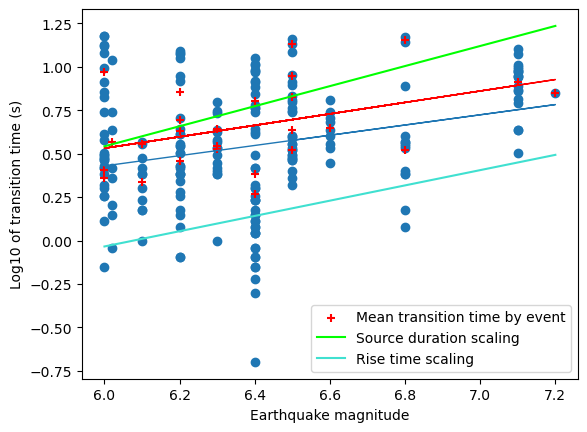

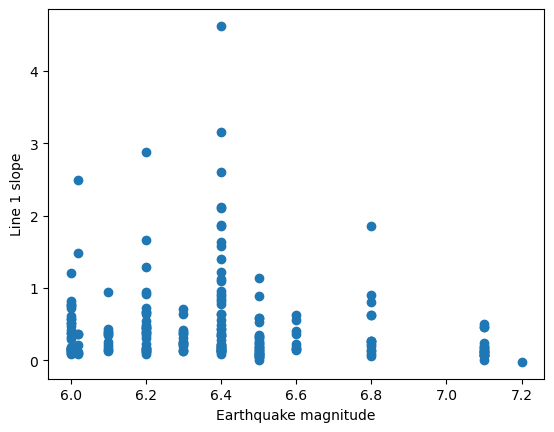

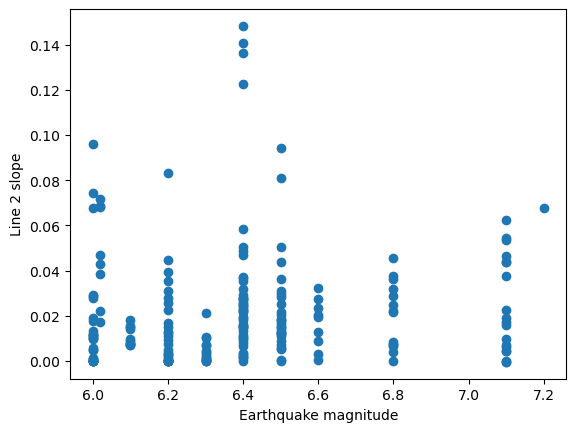

In [19]:
# plt.scatter(mcmc_array[:,3].astype(float), mcmc_array[:,9].astype(float)-10)
# plt.xlabel('Hypocentral distance (km)')
# plt.ylabel('Transition time (s)')
# plt.show()



plt.scatter(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10))
plt.scatter(mags, np.log10(mean_trans_times), marker = '+', color = 'red', label = 'Mean transition time by event')
plt.plot(mags, mags * m + b, color = 'red', lw = 1)
plt.plot(mcmc_array[:,1].astype(float), mcmc_array[:,1].astype(float) * ma + ba, color = 'C0', lw = 1)
plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
# plt.semilogy()
plt.legend()
plt.show()

plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,5].astype(float))
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 1 slope')
plt.show()

plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,6].astype(float))
plt.xlabel('Earthquake magnitude')
plt.ylabel('Line 2 slope')
plt.show()

In [11]:
# mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
#                              np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
#                              np.array(sigmas_list), np.array(trans_time_list)))

pd_mcmc = pd.DataFrame(mcmc_array, columns = ['eq_id', 'mag', 'sta', 'hypdist', 'xhigh', 'm1', 'm2', 'xinter', 'sigma', 'trans_time'])
pd_mcmc.to_csv(path_to_files + '3comp_norm_mcmc_arrays/mcmc_results_summary.csv', index = False)

In [12]:
# Figure out the "good" and "bad" performing waveforms using an L2 norm

mcmc_results = pd.read_csv(path_to_files + '3comp_norm_mcmc_arrays/mcmc_results_summary.csv')
mcmc_results

eq_id  mag   sta  hypdist  xhigh        m1        m2  \
0      2023-04-13_M6  6.0  B006      468     60  0.229002  0.007259   
1      2023-04-13_M6  6.0  B012      299     60  0.212300  0.018549   
2      2023-04-13_M6  6.0  B927      349     60  0.680490  0.008980   
3      2023-04-13_M6  6.0  B928      330     60  0.407427  0.011923   
4    2022-12-20_M6.4  6.4  B030      406     40  0.250818  0.035266   
..               ...  ...   ...      ...    ...       ...       ...   
211  2010-01-10_M6.5  6.5  B035      232     35  0.686144  0.028275   
212  2010-01-10_M6.5  6.5  B036      233     35  0.612501  0.029656   
213  2010-01-10_M6.5  6.5  B057      344     35  0.171922  0.015275   
214  2010-01-10_M6.5  6.5  B933       89     35  1.138508  0.053870   
215  2010-01-10_M6.5  6.5  B935       96     35  1.461021  0.025683   

        xinter     sigma  trans_time  
0    11.837966  0.041712        11.9  
1    12.735132  0.084625        12.8  
2    11.372254  0.052989        11.4  
3    11.760077  0.054794        11.8  
4    14.228573  0.123324        14.3  
..         ...       ...         ...  
211  12.839419  0.161430        12.9  
212  12.895629  0.160594        12.9  
213  16.469921  0.078441        16.5  
214  12.296906  0.143644        12.3  
215  11.878281  0.079195        11.9  

[216 rows x 10 columns]

In [13]:
print(np.mean(mcmc_results['m1'].values))
print(np.mean(mcmc_results['m2'].values))
print(np.mean(mcmc_results['xinter'].values))

print(np.median(mcmc_results['m1'].values))
print(np.median(mcmc_results['m2'].values))
print(np.median(mcmc_results['xinter'].values))

0.4963159588248899
0.021881849915869663
14.37657531649974
0.2909318679360138
0.01348658310043635
13.210267893103396
